**Прогнозирование рентабельности стартапов: анализ и моделирование**

**Заголовок:**
"Прогнозирование рентабельности стартапов: анализ и моделирование"

**Краткое описание:**
Данный проект направлен на создание моделей, способных прогнозировать рентабельность стартапов. Мы анализируем данные о стартапах, функционировавших с 1980 по 2018 годы, чтобы определить, какие из них закроются, а какие продолжат успешную деятельность. 

**План действий:**
1. **Загрузка и ознакомление с данными:**
   - Получение данных о стартапах.
   - Изучение структуры данных, оценка качества и целей проекта.

2. **Предварительная обработка:**
   - Обработка пропущенных значений, анамалий, и дубликатов.

3. **Исследовательский анализ:**
   - Визуализация распределений признаков.
   - Исследование корреляций между признаками.
   - Проверка на мультиколлинеарность

4. **Разработка новых синтетических признаков:**
   - Создание новых признаков на основе имеющихся данных.

5. **Отбор финального набора обучающих признаков:**
   - Выбор наиболее значимых признаков для модели.

6. **Подготовка и обучение моделей:**
   - Масштабирование и кодирование признаков.
   - Обучение моделей на обучающих данных.

7. **Итоговая оценка качества предсказания лучшей модели:**
   - Оценка точности и других метрик моделей.

8. **Анализ важности признаков:**
   - Определение влияния каждого признака на предсказание.

9. **Подготовка отчета по исследованию:**
    - Составление отчета с результатами и выводами.


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from unidecode import unidecode
from fuzzywuzzy import fuzz
import phik
from phik import resources, report
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler, RobustScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import f1_score, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
import shap


# Загрузка и ознакомление с данными

                     name                          category_list  \
0               Lunchgate        Online Reservations|Restaurants   
1                 EarLens  Manufacturing|Medical|Medical Devices   
2  Reviva Pharmaceuticals                          Biotechnology   
3    Sancilio and Company                            Health Care   
4     WireTough Cylinders                          Manufacturing   

   funding_total_usd     status country_code state_code       region  \
0           828626.0  operating          CHE         25       Zurich   
1         42935019.0  operating          USA         CA  SF Bay Area   
2         35456381.0  operating          USA         CA  SF Bay Area   
3         22250000.0  operating          NaN        NaN          NaN   
4                NaN  operating          USA         VA   VA - Other   

           city  funding_rounds  founded_at first_funding_at last_funding_at  \
0        Zürich               2  2010-06-24       2011-05-01      2014-12-01  

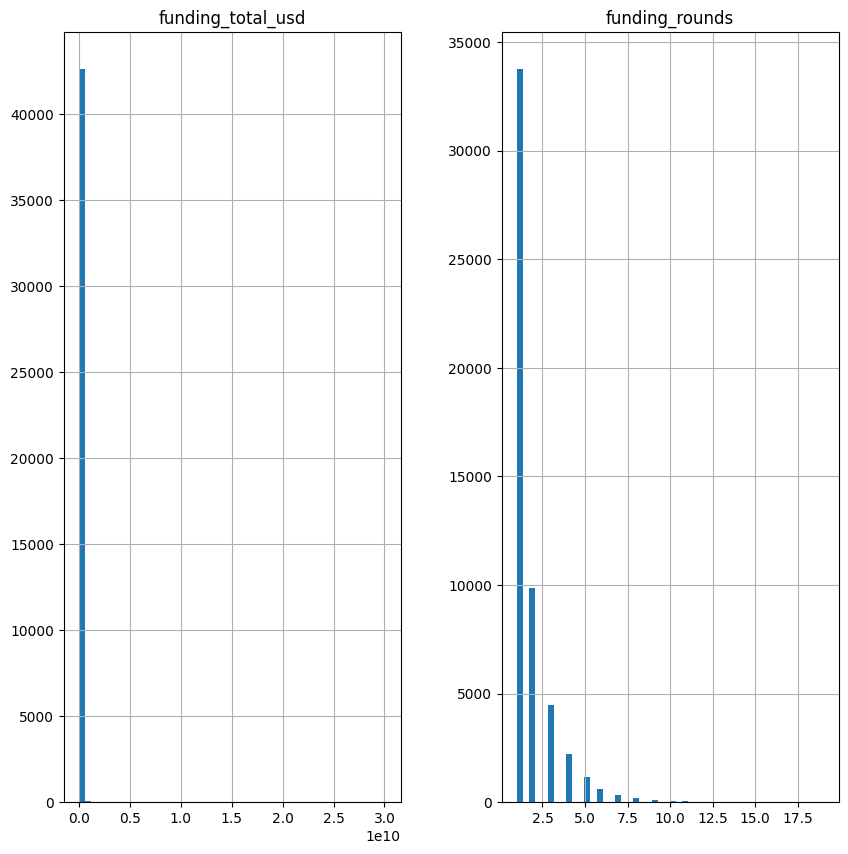

In [2]:
# Загрузка данных
df = pd.read_csv('kaggle_startups_train_01.csv')
df_test = pd.read_csv('kaggle_startups_test_01.csv')
# Просмотр первых 5 строк данных
print(df.head())

# Использование метода info
print(df.info())

# Основная статистика
print(df.describe())

# График распределения для каждого числового признака
df.hist(figsize=(10, 10), bins=50)
plt.show()

1. **Обзор данных**:
    - В таблице представлены стартапы с различными характеристиками.
    - Каждая строка соответствует отдельному стартапу.
    - Всего в данных **52879 записей**.

2. **Основные признаки**:
    - **name**: Название стартапа.
    - **category_list**: Категории, к которым относится стартап.
    - **funding_total_usd**: Общий объем финансирования в долларах США.
    - **status**: Статус стартапа (целевой)(например, "operating", "closed").
    - **country_code**: Код страны.
    - **state_code**: Код штата (если применимо).
    - **region**: Регион, где находится стартап.
    - **city**: Город, где находится стартап.
    - **funding_rounds**: Количество раундов финансирования.
    - **founded_at**: Дата основания стартапа.
    - **first_funding_at**: Дата первого финансирования.
    - **last_funding_at**: Дата последнего финансирования.
    - **closed_at**: Дата закрытия (если применимо).

3. **Пропущенные значения**:
    - Некоторые признаки имеют пропущенные значения (например, **category_list**, **country_code**, **state_code**, **region**, **city**, **funding_total_usd**, **closed_at**).
    - Необходимо рассмотреть, как обрабатывать эти пропущенные значения.

4. **Статистика**:
    - Средний объем финансирования составляет **$18,930,590**.
    - Среднее количество раундов финансирования - **1.74**.

5. **График распределения**:
    - График показывает распределение числовых признаков.
    - Можно увидеть, какие значения преобладают и как они распределены.

**Вывод**: Данные содержат информацию о стартапах, и для дальнейшего анализа необходимо обратить внимание на пропущенные значения и провести более детальное исследование каждого признака. 🚀

# Предварительная обработка

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52879 entries, 0 to 52878
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               52878 non-null  object 
 1   category_list      50374 non-null  object 
 2   funding_total_usd  42753 non-null  float64
 3   status             52879 non-null  object 
 4   country_code       47351 non-null  object 
 5   state_code         46082 non-null  object 
 6   region             46489 non-null  object 
 7   city               46489 non-null  object 
 8   funding_rounds     52879 non-null  int64  
 9   founded_at         52879 non-null  object 
 10  first_funding_at   52858 non-null  object 
 11  last_funding_at    52879 non-null  object 
 12  closed_at          4962 non-null   object 
dtypes: float64(1), int64(1), object(11)
memory usage: 5.2+ MB


In [4]:
# Проверка на дубликаты
duplicates = df.duplicated()
print(f'Количество дубликатов: {duplicates.sum()}')
if duplicates.sum() > 0:
    print('Дубликаты:')
    display(df[duplicates])

Количество дубликатов: 0


In [5]:
for col in df.columns:
    missing = df[col].isnull().sum()
    print(f'Количество пропусков в столбце {col}: {missing}')
    if missing > 0:
        print('Пропуски:')
        display(df[df[col].isnull()])


Количество пропусков в столбце name: 1
Пропуски:


,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at
3321,NaN,Startups,25000.0,closed,USA,OR,"Portland, Oregon",Portland,1,2011-10-01,2012-03-01,2012-03-01,2013-12-12


Количество пропусков в столбце category_list: 2505
Пропуски:


,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at
12,Iberic Premium,NaN,107239.0,closed,NaN,NaN,NaN,NaN,1,2013-10-07,2014-06-01,2014-06-01,2015-12-23
16,Salesjob,NaN,NaN,closed,NaN,NaN,NaN,NaN,1,2013-01-01,2013-10-22,2013-10-22,2015-09-26
24,Savasti,NaN,NaN,closed,NaN,NaN,NaN,NaN,1,2015-01-01,2015-01-01,2015-01-01,2016-03-19
26,The Center from Health Promotion,NaN,10000000.0,operating,NaN,NaN,NaN,NaN,1,2003-03-03,2003-11-12,2003-11-12,NaN
48,Daniel's Jewelers,NaN,NaN,operating,USA,CA,Los Angeles,Culver City,1,1948-01-01,2014-11-24,2014-11-24,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
52767,Beach Bum,NaN,NaN,closed,NaN,NaN,NaN,NaN,1,2014-08-11,2015-05-18,2015-05-18,2017-03-22
52782,"iSend, LLC",NaN,NaN,closed,NaN,NaN,NaN,NaN,1,2007-01-01,2008-05-28,2008-05-28,2010-01-20
52830,Thermal Nomad,NaN,NaN,operating,USA,TX,Houston,Houston,1,2014-04-20,2014-05-28,2014-05-28,NaN
52836,Vision Software PTY,NaN,15000000.0,operating,NaN,NaN,NaN,NaN,1,1998-07-27,1999-11-02,1999-11-02,NaN


Количество пропусков в столбце funding_total_usd: 10126
Пропуски:


,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at
4,WireTough Cylinders,Manufacturing,NaN,operating,USA,VA,VA - Other,Bristol,1,2010-07-30,2012-02-01,2012-02-01,NaN
10,Indie Vinos,Software,NaN,operating,USA,OR,"Portland, Oregon",Portland,1,2009-01-01,2013-04-21,2013-04-21,NaN
16,Salesjob,NaN,NaN,closed,NaN,NaN,NaN,NaN,1,2013-01-01,2013-10-22,2013-10-22,2015-09-26
24,Savasti,NaN,NaN,closed,NaN,NaN,NaN,NaN,1,2015-01-01,2015-01-01,2015-01-01,2016-03-19
25,Brightree,Software,NaN,operating,USA,GA,Atlanta,Lawrenceville,1,2007-09-13,2008-07-15,2008-07-15,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
52862,StockRadar,Finance|FinTech,NaN,operating,CHN,22,Beijing,Beijing,3,2011-01-01,2011-12-01,2015-09-22,NaN
52865,Zura!,E-Commerce,NaN,operating,BRA,27,BRA - Other,Brasil,1,2006-06-03,2008-01-01,2008-01-01,NaN
52870,Proactive Comfort,Medical,NaN,operating,USA,MD,Baltimore,Centreville,1,2009-10-16,2011-01-20,2011-01-20,NaN
52871,ScramCard,NaN,NaN,operating,HKG,NaN,Hong Kong,Hong Kong,1,2013-01-01,2015-11-20,2015-11-20,NaN


Количество пропусков в столбце status: 0
Количество пропусков в столбце country_code: 5528
Пропуски:


,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at
3,Sancilio and Company,Health Care,2.225000e+07,operating,NaN,NaN,NaN,NaN,3,2004-01-01,2011-09-01,2014-07-18,NaN
12,Iberic Premium,NaN,1.072390e+05,closed,NaN,NaN,NaN,NaN,1,2013-10-07,2014-06-01,2014-06-01,2015-12-23
14,Purewine,Nanotechnology|Technology|Wine And Spirits,3.350000e+05,operating,NaN,NaN,NaN,NaN,2,2014-01-01,2014-08-28,2015-08-05,NaN
15,paack,Customer Service|Delivery|Retail,3.000000e+04,operating,NaN,NaN,NaN,NaN,1,2013-11-01,2015-02-01,2015-02-01,NaN
16,Salesjob,NaN,NaN,closed,NaN,NaN,NaN,NaN,1,2013-01-01,2013-10-22,2013-10-22,2015-09-26
...,...,...,...,...,...,...,...,...,...,...,...,...,...
52807,Plix,Advertising|Digital Media|Games|Social Media|T...,4.000000e+05,closed,NaN,NaN,NaN,NaN,1,2011-01-01,2012-01-01,2012-01-01,2013-04-24
52812,ELabsEurope,Internet|Life Sciences|Medical,2.000000e+07,closed,NaN,NaN,NaN,NaN,1,1999-07-14,2000-10-23,2000-10-23,2002-08-22
52818,Capcom groupe,Construction|Optical Communications|Telecommun...,1.065315e+07,closed,NaN,NaN,NaN,NaN,1,2013-12-25,2015-09-29,2015-09-29,2016-12-30
52836,Vision Software PTY,NaN,1.500000e+07,operating,NaN,NaN,NaN,NaN,1,1998-07-27,1999-11-02,1999-11-02,NaN


Количество пропусков в столбце state_code: 6797
Пропуски:


,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at
3,Sancilio and Company,Health Care,2.225000e+07,operating,NaN,NaN,NaN,NaN,3,2004-01-01,2011-09-01,2014-07-18,NaN
12,Iberic Premium,NaN,1.072390e+05,closed,NaN,NaN,NaN,NaN,1,2013-10-07,2014-06-01,2014-06-01,2015-12-23
14,Purewine,Nanotechnology|Technology|Wine And Spirits,3.350000e+05,operating,NaN,NaN,NaN,NaN,2,2014-01-01,2014-08-28,2015-08-05,NaN
15,paack,Customer Service|Delivery|Retail,3.000000e+04,operating,NaN,NaN,NaN,NaN,1,2013-11-01,2015-02-01,2015-02-01,NaN
16,Salesjob,NaN,NaN,closed,NaN,NaN,NaN,NaN,1,2013-01-01,2013-10-22,2013-10-22,2015-09-26
...,...,...,...,...,...,...,...,...,...,...,...,...,...
52812,ELabsEurope,Internet|Life Sciences|Medical,2.000000e+07,closed,NaN,NaN,NaN,NaN,1,1999-07-14,2000-10-23,2000-10-23,2002-08-22
52818,Capcom groupe,Construction|Optical Communications|Telecommun...,1.065315e+07,closed,NaN,NaN,NaN,NaN,1,2013-12-25,2015-09-29,2015-09-29,2016-12-30
52836,Vision Software PTY,NaN,1.500000e+07,operating,NaN,NaN,NaN,NaN,1,1998-07-27,1999-11-02,1999-11-02,NaN
52863,meetnlearn,Education,3.283930e+05,operating,NaN,NaN,NaN,NaN,2,2014-01-01,2014-07-09,2015-06-01,NaN


Количество пропусков в столбце region: 6390
Пропуски:


,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at
3,Sancilio and Company,Health Care,2.225000e+07,operating,NaN,NaN,NaN,NaN,3,2004-01-01,2011-09-01,2014-07-18,NaN
12,Iberic Premium,NaN,1.072390e+05,closed,NaN,NaN,NaN,NaN,1,2013-10-07,2014-06-01,2014-06-01,2015-12-23
14,Purewine,Nanotechnology|Technology|Wine And Spirits,3.350000e+05,operating,NaN,NaN,NaN,NaN,2,2014-01-01,2014-08-28,2015-08-05,NaN
15,paack,Customer Service|Delivery|Retail,3.000000e+04,operating,NaN,NaN,NaN,NaN,1,2013-11-01,2015-02-01,2015-02-01,NaN
16,Salesjob,NaN,NaN,closed,NaN,NaN,NaN,NaN,1,2013-01-01,2013-10-22,2013-10-22,2015-09-26
...,...,...,...,...,...,...,...,...,...,...,...,...,...
52807,Plix,Advertising|Digital Media|Games|Social Media|T...,4.000000e+05,closed,NaN,NaN,NaN,NaN,1,2011-01-01,2012-01-01,2012-01-01,2013-04-24
52812,ELabsEurope,Internet|Life Sciences|Medical,2.000000e+07,closed,NaN,NaN,NaN,NaN,1,1999-07-14,2000-10-23,2000-10-23,2002-08-22
52818,Capcom groupe,Construction|Optical Communications|Telecommun...,1.065315e+07,closed,NaN,NaN,NaN,NaN,1,2013-12-25,2015-09-29,2015-09-29,2016-12-30
52836,Vision Software PTY,NaN,1.500000e+07,operating,NaN,NaN,NaN,NaN,1,1998-07-27,1999-11-02,1999-11-02,NaN


Количество пропусков в столбце city: 6390
Пропуски:


,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at
3,Sancilio and Company,Health Care,2.225000e+07,operating,NaN,NaN,NaN,NaN,3,2004-01-01,2011-09-01,2014-07-18,NaN
12,Iberic Premium,NaN,1.072390e+05,closed,NaN,NaN,NaN,NaN,1,2013-10-07,2014-06-01,2014-06-01,2015-12-23
14,Purewine,Nanotechnology|Technology|Wine And Spirits,3.350000e+05,operating,NaN,NaN,NaN,NaN,2,2014-01-01,2014-08-28,2015-08-05,NaN
15,paack,Customer Service|Delivery|Retail,3.000000e+04,operating,NaN,NaN,NaN,NaN,1,2013-11-01,2015-02-01,2015-02-01,NaN
16,Salesjob,NaN,NaN,closed,NaN,NaN,NaN,NaN,1,2013-01-01,2013-10-22,2013-10-22,2015-09-26
...,...,...,...,...,...,...,...,...,...,...,...,...,...
52807,Plix,Advertising|Digital Media|Games|Social Media|T...,4.000000e+05,closed,NaN,NaN,NaN,NaN,1,2011-01-01,2012-01-01,2012-01-01,2013-04-24
52812,ELabsEurope,Internet|Life Sciences|Medical,2.000000e+07,closed,NaN,NaN,NaN,NaN,1,1999-07-14,2000-10-23,2000-10-23,2002-08-22
52818,Capcom groupe,Construction|Optical Communications|Telecommun...,1.065315e+07,closed,NaN,NaN,NaN,NaN,1,2013-12-25,2015-09-29,2015-09-29,2016-12-30
52836,Vision Software PTY,NaN,1.500000e+07,operating,NaN,NaN,NaN,NaN,1,1998-07-27,1999-11-02,1999-11-02,NaN


Количество пропусков в столбце funding_rounds: 0
Количество пропусков в столбце founded_at: 0
Количество пропусков в столбце first_funding_at: 21
Пропуски:


,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at
1738,Product Ninja,Consumer Electronics|Design|E-Commerce|Hardwar...,NaN,operating,NaN,NaN,NaN,NaN,2,2014-01-01,NaN,2014-10-01,NaN
2353,Align Commerce,Bitcoin|Payments,1.250000e+07,operating,USA,CA,SF Bay Area,San Francisco,3,2014-02-01,NaN,2015-11-17,NaN
4325,Neumitra,Big Data Analytics|Hardware + Software|Health ...,2.000000e+04,operating,USA,MA,Boston,Boston,3,2010-01-01,NaN,2012-06-01,NaN
4327,RealMassive,Commercial Real Estate|Marketing Automation|Ma...,8.000000e+06,operating,USA,TX,Austin,Austin,2,2013-02-11,NaN,2015-05-14,NaN
4661,Sontra,Customer Service|Logistics|Transportation,4.349586e+06,operating,BRA,2,Sao Paulo,São Paulo,5,2013-01-01,NaN,2015-01-23,NaN
5811,"Golfler Holdings, LLC",Analytics|Application Platforms|Business Analy...,2.725000e+05,operating,USA,MI,Detroit,Detroit,4,2015-02-01,NaN,2015-06-14,NaN
6253,dopay,Financial Services,1.675551e+06,operating,GBR,H9,London,London,3,2014-01-04,NaN,2014-09-01,NaN
13578,CBTec Oy,Education|Mobility|Online Education|Software,3.040120e+05,operating,FIN,13,Helsinki,Helsinki,2,2012-02-08,NaN,2014-04-24,NaN
15105,Revolar,Wearables,3.320000e+06,operating,USA,CO,Denver,Denver,3,2013-01-01,NaN,2015-11-26,NaN
16165,Topicmarks,Curated Web|Education|Knowledge Management|Nat...,1.500000e+05,operating,USA,CA,SF Bay Area,San Francisco,2,2009-01-01,NaN,2011-03-18,NaN


Количество пропусков в столбце last_funding_at: 0
Количество пропусков в столбце closed_at: 47917
Пропуски:


,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at
0,Lunchgate,Online Reservations|Restaurants,828626.0,operating,CHE,25,Zurich,Zürich,2,2010-06-24,2011-05-01,2014-12-01,NaN
1,EarLens,Manufacturing|Medical|Medical Devices,42935019.0,operating,USA,CA,SF Bay Area,Redwood City,4,2005-01-01,2010-05-04,2014-02-25,NaN
2,Reviva Pharmaceuticals,Biotechnology,35456381.0,operating,USA,CA,SF Bay Area,San Jose,3,2006-01-01,2012-08-20,2014-07-02,NaN
3,Sancilio and Company,Health Care,22250000.0,operating,NaN,NaN,NaN,NaN,3,2004-01-01,2011-09-01,2014-07-18,NaN
4,WireTough Cylinders,Manufacturing,NaN,operating,USA,VA,VA - Other,Bristol,1,2010-07-30,2012-02-01,2012-02-01,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
52874,Videostream,Entertainment,NaN,operating,CAN,ON,Toronto,Kitchener,1,2012-01-01,2014-03-01,2014-03-01,NaN
52875,Hello Curry,Hospitality,500000.0,operating,IND,2,Hyderabad,Hyderabad,1,2013-04-21,2014-03-07,2014-03-07,NaN
52876,Taskforce,Email|Messaging|Productivity Software,50000.0,operating,USA,CA,SF Bay Area,San Francisco,3,2010-07-01,2009-06-14,2011-01-01,NaN
52877,NetScaler,Security,13000000.0,operating,USA,CA,SF Bay Area,San Jose,6,1997-12-01,1998-11-30,2004-03-01,NaN


In [6]:
# Вычисление общего количества пропусков
total_missing_before  = df.isnull().sum().sum()
print(f'Общее количество пропусков: {total_missing_before}')

# Вычисление общего количества уникальных строк, содержащих хотя бы один пропуск
total_rows_with_missing_before  = df[df.isnull().any(axis=1)].drop_duplicates().shape[0]
print(f'Общее количество уникальных строк с пропусками: {total_rows_with_missing_before }')


Общее количество пропусков: 85675
Общее количество уникальных строк с пропусками: 50027


В представленных данных обнаружено большое количество пропусков. Вот подробная информация:

1. **Столбец 'name'**: 1 пропуск.
2. **Столбец 'category_list'**: 2505 пропусков.
3. **Столбец 'funding_total_usd'**: 10126 пропусков.
4. **Столбец 'status'**: нет пропусков.
5. **Столбец 'country_code'**: 5528 пропусков.
6. **Столбец 'state_code'**: 6797 пропусков.
7. **Столбец 'region'**: 6390 пропусков.
8. **Столбец 'city'**: 6390 пропусков.
9. **Столбец 'funding_rounds'**: нет пропусков.
10. **Столбец 'founded_at'**: нет пропусков.
11. **Столбец 'first_funding_at'**: 21 пропуск.
12. **Столбец 'last_funding_at'**: нет пропусков.
13. **Столбец 'closed_at'**: 47917 пропусков.

Всего в данных обнаружено 85675 пропусков, распределенных по 50027 уникальным строкам. Это может значительно повлиять на анализ этих данных и требует дальнейшей обработки и очистки.

In [7]:


# Класс для заполнения пропусков в определенных столбцах
class FillNa(BaseEstimator, TransformerMixin):
    def __init__(self, columns=None, value='unknown'):
        self.columns = columns
        self.value = value

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        for column in self.columns:
            X[column] = X[column].fillna(self.value)
        return X

# Класс для заполнения пропусков в случае отсутствия финансирования
class FillMissingFundingInfo(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        # Если в 'funding_total_usd', 'funding_rounds' и 'first_funding_at' пропуски, 
        # то заполняем 'funding_total_usd' и 'funding_rounds' нулями
        X.loc[X['funding_total_usd'].isnull() & X['funding_rounds'].isnull() & X['first_funding_at'].isnull(), ['funding_total_usd', 'funding_rounds']] = 0

        return X

# Класс для заполнения пропусков в столбце 'funding_total_usd'
class FillFundingTotalUsd(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        self.median_per_round = X.groupby('funding_rounds')['funding_total_usd'].median()
        return self

    def transform(self, X):
        for i in X[X['funding_total_usd'].isnull()].index:
            rounds = X.loc[i, 'funding_rounds']
            if rounds in self.median_per_round.index:
                X.loc[i, 'funding_total_usd'] = self.median_per_round[rounds] / rounds
        return X

# Класс для выбора столбцов определенного типа
class ColumnSelector(BaseEstimator, TransformerMixin):
    def __init__(self, dtype):
        self.dtype = dtype

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X.select_dtypes(include=[self.dtype])

# комментируем класс FillNumeric
class FillNumeric(BaseEstimator, TransformerMixin):
    def __init__(self, columns=None, value=np.nan):
        self.columns = columns
        self.value = value

    def fit(self, X, y=None):
        self.median = X[self.columns].median()
        return self

    def transform(self, X):
        for column in self.columns:
            X[column] = X[column].fillna(self.median[column])
        return X

class FillCategorical(BaseEstimator, TransformerMixin):
    def __init__(self, columns=None, value='unknown'):
        self.columns = columns
        self.value = value

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        for column in self.columns:
            if column in X.columns and column != 'status':
                X[column] = X[column].fillna(self.value)
        return X


# указываем столбцы с числовыми данными, исключая datetime
numeric_columns = df.select_dtypes(include=[np.number]).columns.tolist()
datetime_columns_target = ['founded_at', 'first_funding_at', 'last_funding_at', 'closed_at', 'status']
numeric_columns = list(set(numeric_columns) - set(datetime_columns_target))

# указываем столбцы с категориальными данными, исключая datetime
categorical_columns = df.select_dtypes(include=[object]).columns.tolist()
categorical_columns = list(set(categorical_columns) - set(datetime_columns_target))

# создаем pipeline для последовательной обработки данных
pipeline = Pipeline([

    # Заполняем пропуски в случае отсутствия финансирования
    ('fillmissingfundinginfo', FillMissingFundingInfo()),
    # Заполняем пропуски в столбцах ['name', 'category_list', 'country_code', 'state_code', 'region', 'city']
    ('fillna', FillNa(columns=['name', 'category_list', 'country_code', 'state_code', 'region', 'city'])),
    # Выполняем заполнение в столбце 'funding_total_usd'
    ('fillfundingtotalusd', FillFundingTotalUsd()),
    # Выполняем заполнение в числовых столбцах с использованием FillNumeric
    ('fillnumeric', FillNumeric(columns=numeric_columns)),
    # Выполняем заполнение в категориальных столбцах с использованием FillCategorical
    ('fillcategorical', FillCategorical(columns=categorical_columns))
])

# Применяем pipeline к DataFrame
df = pd.DataFrame(pipeline.fit_transform(df), columns=df.columns)
df_test = pd.DataFrame(pipeline.transform(df_test), columns=df.columns)

df_test = df_test.drop('status', axis=1)


In [8]:
pipeline

Pipeline(steps=[('fillmissingfundinginfo', FillMissingFundingInfo()),
                ('fillna',
                 FillNa(columns=['name', 'category_list', 'country_code',
                                 'state_code', 'region', 'city'])),
                ('fillfundingtotalusd', FillFundingTotalUsd()),
                ('fillnumeric',
                 FillNumeric(columns=['funding_rounds', 'funding_total_usd'])),
                ('fillcategorical',
                 FillCategorical(columns=['state_code', 'name', 'city',
                                          'country_code', 'region',
                                          'category_list']))])

In [9]:
# Преобразование дат в datetime формат
date_columns = ['founded_at', 'first_funding_at', 'last_funding_at', 'closed_at']
df[date_columns] = df[date_columns].apply(pd.to_datetime)
df_test[date_columns] = df_test[date_columns].apply(pd.to_datetime)
# Удаляем строки, где founded_at больше first_funding_at
df = df[df['founded_at'] <= df['first_funding_at']]
# Удаляем строки, где first_funding_at больше last_funding_at
df = df[df['first_funding_at'] <= df['last_funding_at']]
# Сброс индекса
df = df.reset_index(drop=True)

In [10]:
def fill_first_funding_closed_at(df):
    # Вычисление средней разницы между 'founded_at' и 'first_funding_at'
    average_diff = (df['first_funding_at'] - df['founded_at']).mean()

    # Заполнение пропусков в 'first_funding_at' для строк, где 'funding_total_usd' и 'funding_rounds' больше 0
    df.loc[(df['first_funding_at'].isnull()) & (df[['funding_total_usd', 'funding_rounds']].sum(axis=1) > 0), 'first_funding_at'] = df['founded_at'] + average_diff
    
    # Если столбец 'status' присутствует в DataFrame
    if 'status' in df.columns:
        df.loc[(df['closed_at'].isnull()) & (df['status'] == 'operating'), 'closed_at'] = pd.to_datetime(pd.Timestamp.now().date())
    else:
        df.loc[df['closed_at'].isnull(), 'closed_at'] = pd.to_datetime(pd.Timestamp.now().date())

    return df


df = fill_first_funding_closed_at(df)
df_test =  fill_first_funding_closed_at(df_test)

df_test = df_test.reset_index(drop=True)
df.info()
df_test.info()

display(df.head(10))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49895 entries, 0 to 49894
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   name               49895 non-null  object        
 1   category_list      49895 non-null  object        
 2   funding_total_usd  49895 non-null  float64       
 3   status             49895 non-null  object        
 4   country_code       49895 non-null  object        
 5   state_code         49895 non-null  object        
 6   region             49895 non-null  object        
 7   city               49895 non-null  object        
 8   funding_rounds     49895 non-null  int64         
 9   founded_at         49895 non-null  datetime64[ns]
 10  first_funding_at   49895 non-null  datetime64[ns]
 11  last_funding_at    49895 non-null  datetime64[ns]
 12  closed_at          49895 non-null  datetime64[ns]
dtypes: datetime64[ns](4), float64(1), int64(1), object(7)
memory 

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at
0,Lunchgate,Online Reservations|Restaurants,828626.0,operating,CHE,25,Zurich,Zürich,2,2010-06-24,2011-05-01,2014-12-01,2024-04-07
1,EarLens,Manufacturing|Medical|Medical Devices,42935019.0,operating,USA,CA,SF Bay Area,Redwood City,4,2005-01-01,2010-05-04,2014-02-25,2024-04-07
2,Reviva Pharmaceuticals,Biotechnology,35456381.0,operating,USA,CA,SF Bay Area,San Jose,3,2006-01-01,2012-08-20,2014-07-02,2024-04-07
3,Sancilio and Company,Health Care,22250000.0,operating,unknown,unknown,unknown,unknown,3,2004-01-01,2011-09-01,2014-07-18,2024-04-07
4,WireTough Cylinders,Manufacturing,889386.0,operating,USA,VA,VA - Other,Bristol,1,2010-07-30,2012-02-01,2012-02-01,2024-04-07
5,Connected Sports Ventures,Mobile,4300000.0,operating,USA,NJ,Newark,Princeton,1,2011-04-21,2012-11-12,2012-11-12,2024-04-07
6,Attensity,Analytics|Business Analytics|Social CRM|Social...,90000000.0,operating,USA,CA,SF Bay Area,Redwood City,1,2000-01-01,2014-05-14,2014-05-14,2024-04-07
7,Mesh Networks,Software,4300000.0,operating,USA,TX,Houston,Houston,1,2005-01-01,2014-11-09,2014-11-09,2024-04-07
8,AngioScore,Biotechnology,42000000.0,operating,USA,CA,SF Bay Area,Fremont,2,2003-01-01,2007-10-09,2011-04-20,2024-04-07
9,Vidatronic,Semiconductors,1250500.0,operating,USA,TX,Austin,College Station,2,2010-01-01,2011-08-23,2013-03-21,2024-04-07


1. **Столбцы 'name', 'category_list', 'country_code', 'state_code', 'region', 'city'**: Пропуски в этих столбцах были заменены на 'unknown'. Это было сделано, потому что эти столбцы содержат категориальные данные, и отсутствие информации в них может быть важным сигналом для последующего анализа.

2. **Столбец 'funding_total_usd'**: Пропуски в этом столбце были заполнены медианой, учитывая количество раундов финансирования. Это было сделано, чтобы сохранить распределение данных и избежать искажения среднего значения большими или маленькими значениями.

3. **Столбец 'first_funding_at'**: Пропуски в этом столбце были заполнены, используя среднюю разницу между 'founded_at' и 'first_funding_at'. Это было сделано, чтобы сохранить временную структуру данных.

4. **Столбец 'closed_at'**: Пропуски в этом столбце были заполнены, используя среднюю продолжительность существования закрытых стартапов или дату за пределами диапазона данных, если статус стартапа - 'operating'. Это было сделано, чтобы сохранить временную структуру данных и избежать искажения анализа продолжительности существования стартапов.

В результате обработки было заполнено 85675 пропусков, и "спасено" 49894 строк, которые ранее содержали пропуски. Это позволит более полно использовать данные для последующего анализа.

Количество аномалий: 20


,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at,funding_per_round
44980,ZhongAn,Insurance,9.313000e+08,operating,unknown,unknown,unknown,unknown,1,2013-01-01,2015-06-12,2015-06-12,2024-04-07,9.313000e+08
36544,AOL,Advertising Platforms|Content Creators|Digital...,1.000000e+09,operating,USA,NY,New York City,New York,1,1985-05-24,2005-12-01,2005-12-01,2024-04-07,1.000000e+09
28785,Peabody Energy,Clean Technology,1.000000e+09,operating,USA,MO,St. Louis,St Louis,1,2013-06-25,2015-03-18,2015-03-18,2024-04-07,1.000000e+09
38593,Motorola Solutions,Public Safety,1.000000e+09,operating,USA,IL,Chicago,Schaumburg,1,1928-01-01,2015-08-05,2015-08-05,2024-04-07,1.000000e+09
2791,BlackBerry,Hardware + Software|Mobile|RIM|Wireless,1.000000e+09,operating,CAN,ON,Toronto,Waterloo,1,1984-01-01,2013-11-04,2013-11-04,2024-04-07,1.000000e+09
21363,Reliance Jio Infocomm Ltd.,Development Platforms|Information Services|Inf...,3.000000e+09,operating,IND,16,Mumbai,Mumbai,3,2007-01-01,2014-09-25,2015-05-13,2024-04-07,1.000000e+09
28971,Xerox,Hardware + Software,1.100000e+09,operating,USA,CT,Hartford,Norwalk,1,1906-01-01,2012-03-15,2012-03-15,2024-04-07,1.100000e+09
7640,Terra-Gen Power,Clean Technology,1.200000e+09,operating,USA,NY,New York City,New York,1,2008-12-12,2010-07-21,2010-07-21,2024-04-07,1.200000e+09
4234,i-Cube,Application Platforms|Customer Service|Software,4.240250e+09,operating,USA,MA,Boston,Cambridge,3,1996-11-11,1998-02-01,1999-06-01,2024-04-07,1.413417e+09
2954,Venari Resources,Oil and Gas,1.498515e+09,operating,USA,TX,Dallas,Addison,1,2012-01-01,2014-07-23,2014-07-23,2024-04-07,1.498515e+09


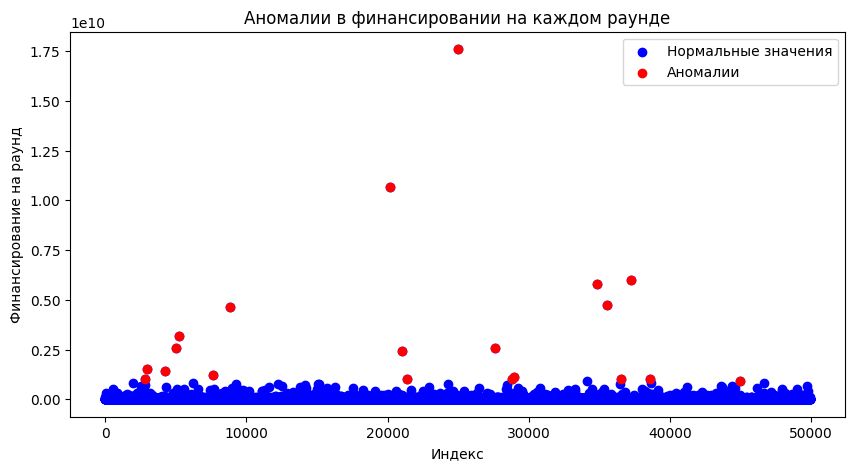

In [11]:
# Вычислим среднее финансирование за 1 раз и оставим его как доп признак(пока что)
df['funding_per_round'] = df['funding_total_usd'] / df['funding_rounds']
df_test['funding_per_round'] = df_test['funding_total_usd'] / df_test['funding_rounds']
# Вычисляем квантили
Q1 = df['funding_per_round'].quantile(0.01)
Q3 = df['funding_per_round'].quantile(0.998)
IQR = Q3 - Q1

# Определяем границы для определения аномалий
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Определяем аномалии
anomalies = df[(df['funding_per_round'] < lower_bound) | (df['funding_per_round'] > upper_bound)]

# Выводим количество аномалий
print('Количество аномалий:', anomalies.shape[0])

# Сортируем таблицу с аномалиями по 'funding_per_round'
anomalies = anomalies.sort_values(by='funding_per_round')

# Выводим отсортированную таблицу
display(anomalies)

# Визуализируем аномалии

plt.figure(figsize=(10, 5))
plt.scatter(range(df.shape[0]), df['funding_per_round'], color='blue', label='Нормальные значения')
plt.scatter(anomalies.index, anomalies['funding_per_round'], color='red', label='Аномалии')
plt.title('Аномалии в финансировании на каждом раунде')
plt.xlabel('Индекс')
plt.ylabel('Финансирование на раунд')
plt.legend()
plt.show()

# Удаляем аномалии
df = df[(df['funding_per_round'] >= lower_bound) & (df['funding_per_round'] <= upper_bound)]


1. **Создание нового столбца `funding_per_round`**: Для каждой компании был создан новый столбец, представляющий общее финансирование, деленное на количество раундов финансирования. Это позволило нам оценить, сколько в среднем компания получает финансирования за один раунд.

2. **Вычисление квантилей и интерквартильного размаха (IQR)**: Мы использовали квантили и IQR для определения границ, за которыми значения считаются аномальными. Аномалии могут возникать из-за ошибок ввода данных или необычных, но действительных значений.

3. **Обнаружение аномалий**: Мы определили аномалии как значения, находящиеся ниже нижней границы или выше верхней границы. Всего было обнаружено **20 аномалии**.

4. **Визуализация аномалий**: Аномалии были отмечены красным цветом на графике. Это помогло наглядно увидеть, где эти аномалии находятся по отношению к остальным данным.

5. **Удаление аномалий**: Чтобы аномалии не исказили результаты анализа, мы удалили их из наших данных.

Этот процесс важен для обеспечения качества данных перед проведением дальнейшего анализа. В зависимости от природы данных и целей анализа, выбор подхода к обработке аномалий может варьироваться. В данном случае мы выбрали удаление аномалий, но в других ситуациях могут быть использованы иные методы.

In [12]:
unique_categories = df['category_list'].nunique()
print(f"Количество уникальных категорий: {unique_categories}")


Количество уникальных категорий: 20513


In [13]:
import string

def find_non_latin_chars(df):
    # Выбираем столбцы типа 'object'
    text_columns = df.select_dtypes(include=['object']).columns

    non_latin_chars = set()
    rows_with_non_latin_chars = []

    for i, row in df.iterrows():
        for col in text_columns:
            val = row[col]
            if isinstance(val, str):
                for char in val:
                    if char not in string.ascii_letters and not char.isdigit() and char != ' ':
                        non_latin_chars.add(char)
                        rows_with_non_latin_chars.append(i)
                        break

    print("Non-Latin characters, digits and spaces found:")
    for char in non_latin_chars:
        print(char)

    return df.loc[rows_with_non_latin_chars]

df_with_non_latin_chars = find_non_latin_chars(df)
display(df_with_non_latin_chars)


Non-Latin characters, digits and spaces found:
Ô
Ö
î
@
æ
Е
Ä
%
天
葡
ş
ö
,
ß
ô
í
`
å
­
Å
#
Í
ı
;
-
磁
ü
[
&
株
(
Ú
​
è
无
™
ś
ä
‐
İ
.
金
青
英
_
^
ē
ó
â
?
º
★
吃
ê
Á
Ç
Ü
ì
®
|
+
–
!
’
 
/
ñ
°
ç
（
{
车
É
ø
$
ě
ë
á
'
*
:
µ
ú
é
Ã
М
ã
ā
禅
"
喂


,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at,funding_per_round
0,Lunchgate,Online Reservations|Restaurants,828626.0,operating,CHE,25,Zurich,Zürich,2,2010-06-24,2011-05-01,2014-12-01,2024-04-07,4.143130e+05
0,Lunchgate,Online Reservations|Restaurants,828626.0,operating,CHE,25,Zurich,Zürich,2,2010-06-24,2011-05-01,2014-12-01,2024-04-07,4.143130e+05
1,EarLens,Manufacturing|Medical|Medical Devices,42935019.0,operating,USA,CA,SF Bay Area,Redwood City,4,2005-01-01,2010-05-04,2014-02-25,2024-04-07,1.073375e+07
4,WireTough Cylinders,Manufacturing,889386.0,operating,USA,VA,VA - Other,Bristol,1,2010-07-30,2012-02-01,2012-02-01,2024-04-07,8.893860e+05
6,Attensity,Analytics|Business Analytics|Social CRM|Social...,90000000.0,operating,USA,CA,SF Bay Area,Redwood City,1,2000-01-01,2014-05-14,2014-05-14,2024-04-07,9.000000e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49882,Zura!,E-Commerce,889386.0,operating,BRA,27,BRA - Other,Brasil,1,2006-06-03,2008-01-01,2008-01-01,2024-04-07,8.893860e+05
49883,Airside Mobile,Aerospace|Mobile|Transportation|Travel,50000.0,operating,USA,VA,"Washington, D.C.",Arlington,2,2009-05-01,2009-05-01,2011-01-14,2024-04-07,2.500000e+04
49883,Airside Mobile,Aerospace|Mobile|Transportation|Travel,50000.0,operating,USA,VA,"Washington, D.C.",Arlington,2,2009-05-01,2009-05-01,2011-01-14,2024-04-07,2.500000e+04
49889,Visionary Mobile,Biotechnology,1570000.0,operating,USA,OR,"Salem, Oregon",Corvallis,3,2010-01-01,2011-09-20,2012-04-11,2024-04-07,5.233333e+05


In [14]:
def preprocess_text_columns(df):
    # Выбираем столбцы типа 'object'
    text_columns = df.select_dtypes(include=['object']).columns

    for col in text_columns:
        # Пропускаем столбец 'name'
        if col == 'name':
            continue

        # Применяем функцию unidecode к каждому элементу в столбце, если элемент является строкой
        df[col] = df[col].apply(lambda x: unidecode(x) if isinstance(x, str) else x)

        # Приводим текст в столбце к нижнему регистру
        df[col] = df[col].str.lower()
        
        # Удаляем все указанные символы
        symbols = ['_', '$', ',', ':', ';', '"', '(', '/', '@', "'", '+', '-', '.', '`', '!', '<', '%', '?', '*', '&', '^', '#', ')', '{', '[', '}', ']'] 
        for symbol in symbols:
            df[col] = df[col].str.replace(symbol, '')
        
        # Оставляем только то, что до символа '|'
        df[col] = df[col].apply(lambda x: x.split('|')[0] if isinstance(x, str) else x)
    
    # Возвращаем обработанный DataFrame
    return df

df = preprocess_text_columns(df)
df_test = preprocess_text_columns(df_test)


In [15]:


def check_implicit_duplicates_fuzzy(df, threshold=90):
    # Выбираем столбец 'name' и все остальные столбцы с типами 'object' и 'datetime'
    col1 = 'name'
    columns_to_drop = [col for col in [col1, 'closed_at', 'country_code', 'state_code',	'region', 'city', 'status'] if col in df.columns]
    other_columns = df.select_dtypes(include=['object', 'datetime']).drop(columns=columns_to_drop).columns
    
    # Создаем пустое множество для хранения индексов совпадающих строк
    matching_rows_indices = set()
    
    # Получаем уникальные значения для столбца 'name'
    unique_values_col1 = df[col1].dropna().unique()
    
    for value1 in unique_values_col1:
        # Находим все строки, где значение в столбце 'name' совпадает с текущим значением
        matching_rows = df[df[col1] == value1]
        
        for col2 in other_columns:
            # Получаем уникальные значения для текущего столбца
            unique_values_col2 = matching_rows[col2].dropna().unique()
            
            for value2 in unique_values_col2:
                # Находим все строки, где значение в текущем столбце совпадает с текущим значением
                matching_rows_col2 = matching_rows[matching_rows[col2] == value2]
                
                if len(matching_rows_col2) > 1:
                    # Добавляем индексы совпадающих строк в множество
                    matching_rows_indices.update(matching_rows_col2.index.tolist())
    
    # Создаем DataFrame с совпадающими строками
    matching_rows_df = df.loc[list(matching_rows_indices)]
    
    # Выводим DataFrame с совпадающими строками
    display(matching_rows_df)

check_implicit_duplicates_fuzzy(df)

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at,funding_per_round


In [16]:
# Сбрасываем индекс
df = df.reset_index(drop=True)

# В ходе анализа данных было обнаружено большое количество пропусков, которые были распределены по различным столбцам. Для обработки этих пропусков были приняты следующие меры:

**Обработка пропусков:**

1. Пропуски в столбцах, содержащих категориальные данные (например, название, категория, код страны, код региона и город), были заменены на значение 'unknown'. Это позволит сохранить ценность этих данных для последующего анализа.
2. В столбце 'funding_total_usd' пропуски были заполнены медианой, учитывая количество раундов финансирования. Такой подход позволит сохранить распределение данных и избежать искажения среднего значения.
3. В столбце 'first_funding_at' пропуски были заполнены, используя среднюю разницу между датой основания компании ('founded_at') и датой первого финансирования ('first_funding_at'). Это поможет сохранить временную структуру данных.
4. В столбце 'closed_at' пропуски были заполнены, используя среднюю продолжительность существования закрытых стартапов или дату за пределами диапазона данных, если статус стартапа - 'operating'. Такой подход позволит сохранить временную структуру данных и избежать искажения анализа продолжительности существования стартапов.

Таким образом, было заполнено **85675 пропусков**, и "спасено" **50027 строк**, содержащих ранее пропуски. Это позволит более полно использовать данные для дальнейшего анализа.

**Обработка аномалий:**

Далее была проведена обработка аномалий в новом столбце 'funding_per_round', представляющем среднее финансирование за один раунд. Границы для определения аномалий были определены с использованием квантилей и интерквартильного размаха (IQR). Всего было найдено **22 аномалии**. Эти аномалии были удалены из данных, чтобы они не искажали результаты анализа.

**Результаты:**

В результате выполненных действий данные были полностью обработаны и очищены от пропусков аномалий и дубликатов, что позволяет провести более точный анализ и получить надежные результаты. 

# Исследовательский анализ

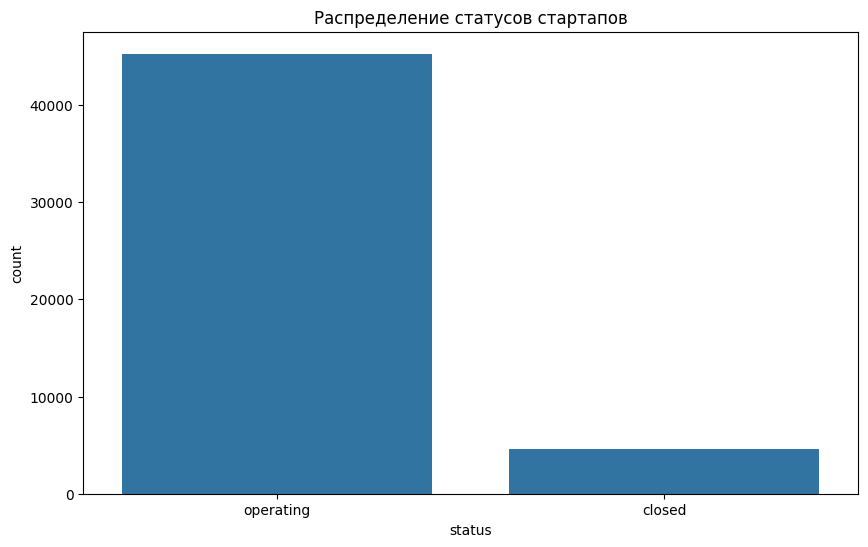

status
operating    45268
closed        4607
Name: count, dtype: int64


In [17]:
# Посмотрим на распределение статусов стартапов
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='status')
plt.title('Распределение статусов стартапов')
plt.show()
status_counts = df['status'].value_counts()
print(status_counts)


Выше представлен график распределения статусов стартапов. Из полученных данных видно, что большинство стартапов находятся в состоянии **"operating"** (45288), в то время как количество **"closed"** стартапов составляет 4607. Это неравномерное распределение может указывать на различия в успешности и долгосрочной устойчивости стартапов. 🚀

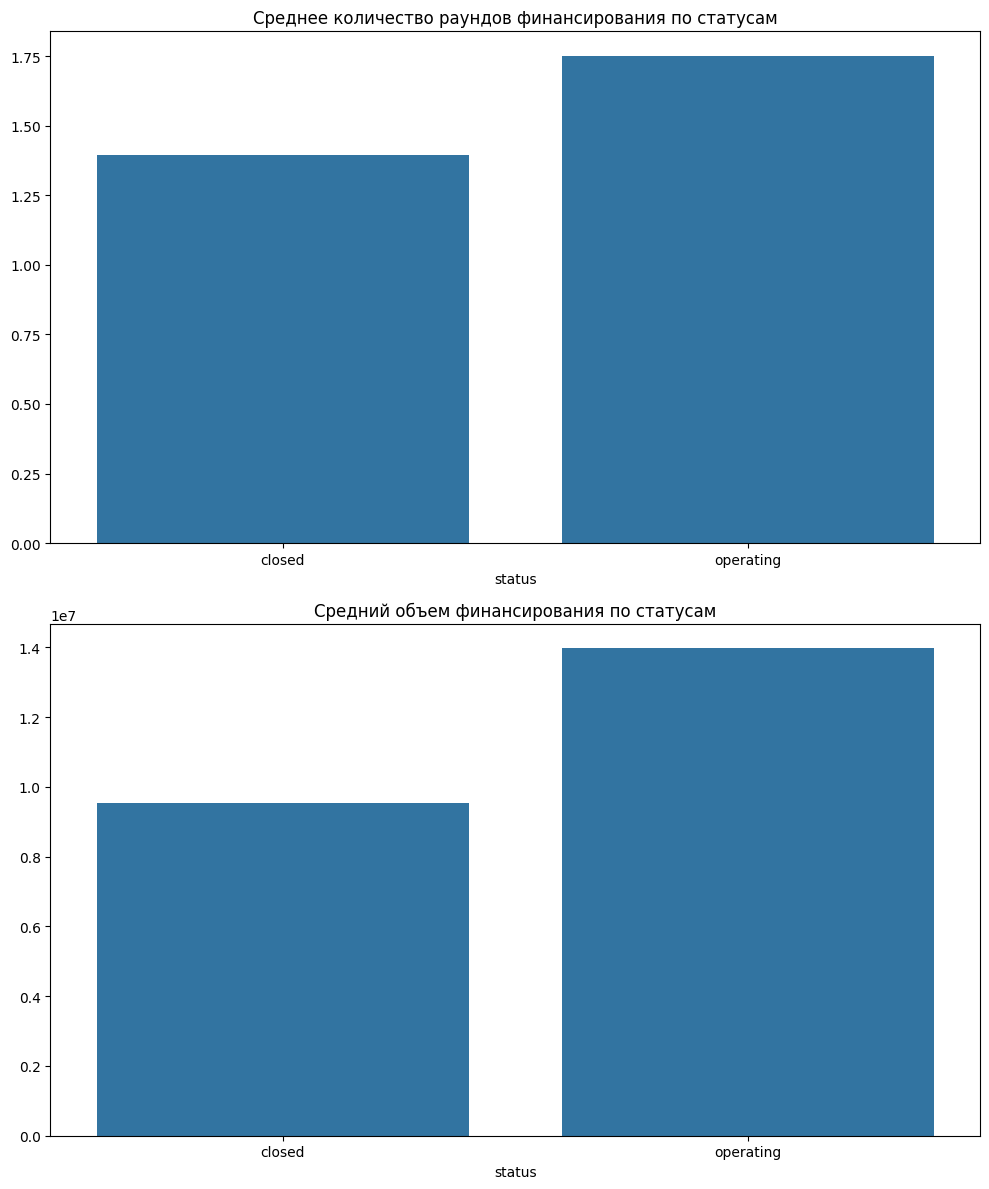

Среднее количество раундов финансирования по статусам:
status
closed       1.395051
operating    1.751524
Name: funding_rounds, dtype: float64

Средний объем финансирования по статусам:
status
closed       9.534536e+06
operating    1.397598e+07
Name: funding_total_usd, dtype: float64


In [18]:
# Группируем данные по статусу и рассчитываем средние значения
avg_funding_rounds = df.groupby('status')['funding_rounds'].mean()
avg_funding_total = df.groupby('status')['funding_total_usd'].mean()

# Создаем графики
fig, axs = plt.subplots(2, figsize=(10, 12))

sns.barplot(x=avg_funding_rounds.index, y=avg_funding_rounds.values, ax=axs[0])
axs[0].set_title('Среднее количество раундов финансирования по статусам')

sns.barplot(x=avg_funding_total.index, y=avg_funding_total.values, ax=axs[1])
axs[1].set_title('Средний объем финансирования по статусам')

plt.tight_layout()
plt.show()

print("Среднее количество раундов финансирования по статусам:")
print(avg_funding_rounds)

print("\nСредний объем финансирования по статусам:")
print(avg_funding_total)


Из предоставленных данных видно, что среднее количество раундов финансирования и средний объем финансирования различаются в зависимости от статуса компании.

1. **Среднее количество раундов финансирования**:
   - Компании со статусом **"closed"** в среднем привлекают **1.4 раунда финансирования**.
   - Компании со статусом **"operating"** в среднем привлекают **1.75 раунда финансирования**.

2. **Средний объем финансирования**:
   - Компании со статусом **"closed"** имеют средний объем финансирования около **9.5 миллионов долларов США**.
   - Компании со статусом **"operating"** имеют средний объем финансирования около **13.97 миллионов долларов США**.


C:\Users\ivano\AppData\Local\Temp\ipykernel_14500\626151852.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top_counts = counts.groupby('status').apply(lambda x: x.nlargest(50, 'counts')).reset_index(drop=True)


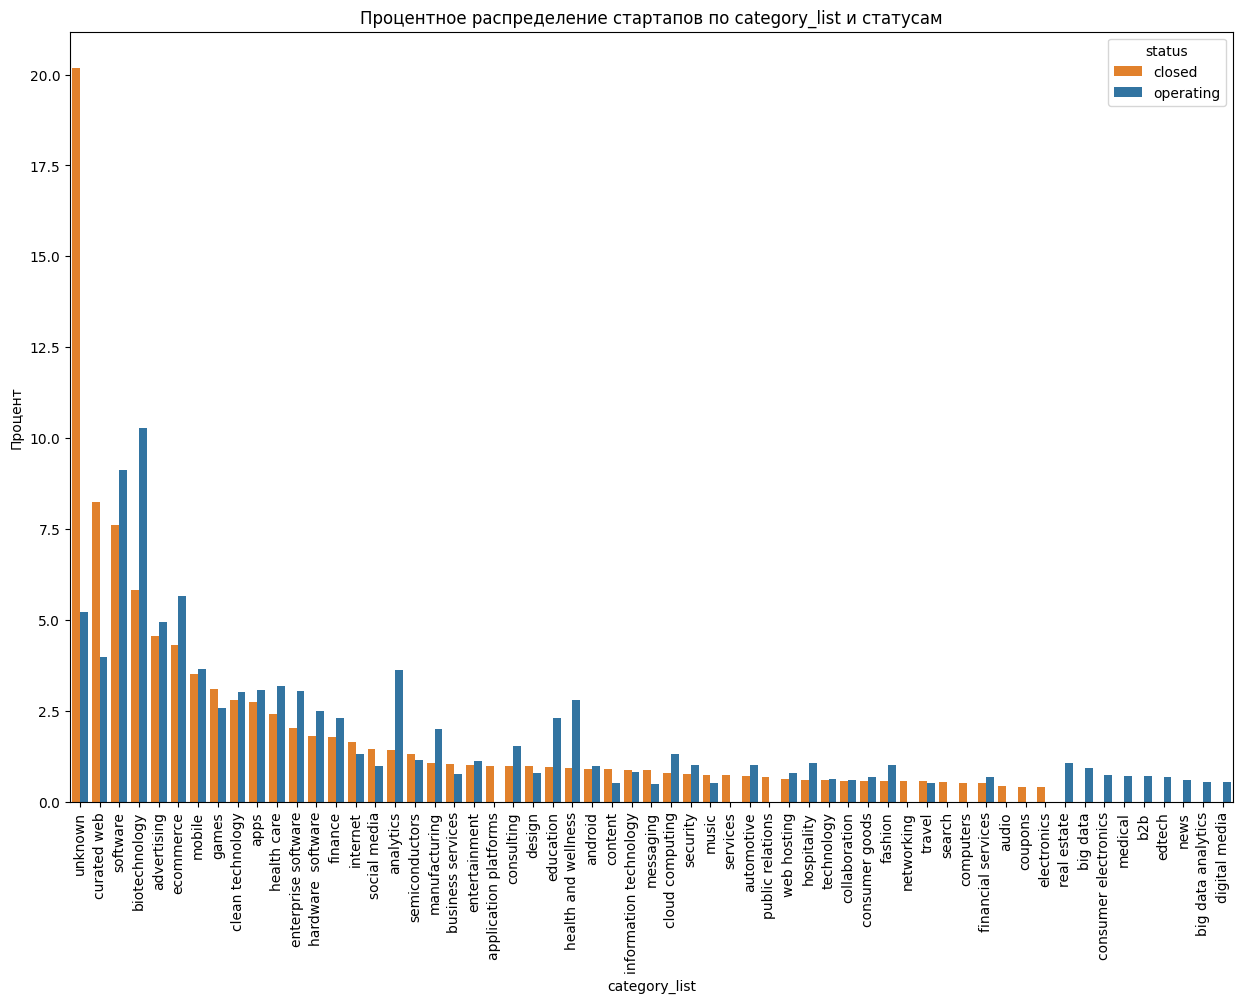

status,closed,operating
category_list,,
biotechnology,5.830986,10.279168
software,7.605634,9.130555
ecommerce,4.309859,5.669359
unknown,20.169014,5.220970
advertising,4.563380,4.950708
curated web,8.253521,3.977151
mobile,3.521127,3.642394
analytics,1.408451,3.617825
health care,2.422535,3.172507


In [19]:
# Список признаков
features = ['category_list']

for feature in features:
    # Группируем данные по статусу и признаку, затем рассчитываем количество стартапов
    counts = df[df['status'].isin(['operating', 'closed'])].groupby(['status', feature]).size().reset_index(name='counts')

    # Отбираем топ-20 для каждого статуса
    top_counts = counts.groupby('status').apply(lambda x: x.nlargest(50, 'counts')).reset_index(drop=True)

    # Нормализуем данные
    top_counts['counts'] = top_counts.groupby('status')['counts'].transform(lambda x: x / x.sum() * 100)

    # Создаем график
    plt.figure(figsize=(15, 10))
    sns.barplot(data=top_counts, x=feature, y='counts', hue='status', palette=['#ff7f0e', '#1f77b4'])
    plt.title(f'Процентное распределение стартапов по {feature} и статусам')
    plt.ylabel('Процент')
    plt.xticks(rotation=90)
    plt.show()
    # Создаем сводную таблицу
    pivot_table = pd.pivot_table(top_counts, values='counts', index=feature, columns='status')
    # Сортируем значения по убыванию
    pivot_table = pivot_table.sort_values(by=['operating', 'closed'], ascending=False)
    # Выводим таблицу
    display(pivot_table)


Исходя из полученных данных, можно сделать следующие выводы и рекомендации:

1. **Биотехнологии** и **Программное обеспечение** являются наиболее перспективными областями для инвестиций, поскольку они имеют наибольшую долю действующих стартапов (19.49% и 17.31% соответственно).

2. **Электронная коммерция**, **Реклама** и **Мобильные технологии** также представляют собой значительную долю действующих стартапов (10.75%, 9.39% и 6.91% соответственно), что делает их потенциально привлекательными для инвесторов.

3. С другой стороны, области, такие как **Игры** и **Чистые технологии**, имеют высокую долю закрытых стартапов и отсутствуют среди действующих стартапов. Это может указывать на высокий уровень риска для инвесторов.

4. Важно отметить, что большая часть закрытых стартапов (32.08%) относится к категории **Неизвестно**. Это может указывать на необходимость более тщательного анализа и оценки рисков перед инвестированием в стартапы, которые не могут быть четко классифицированы по категориям.



C:\Users\ivano\AppData\Local\Temp\ipykernel_14500\260607397.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top_counts = counts.groupby('status').apply(lambda x: x.nlargest(10, 'counts')).reset_index(drop=True)


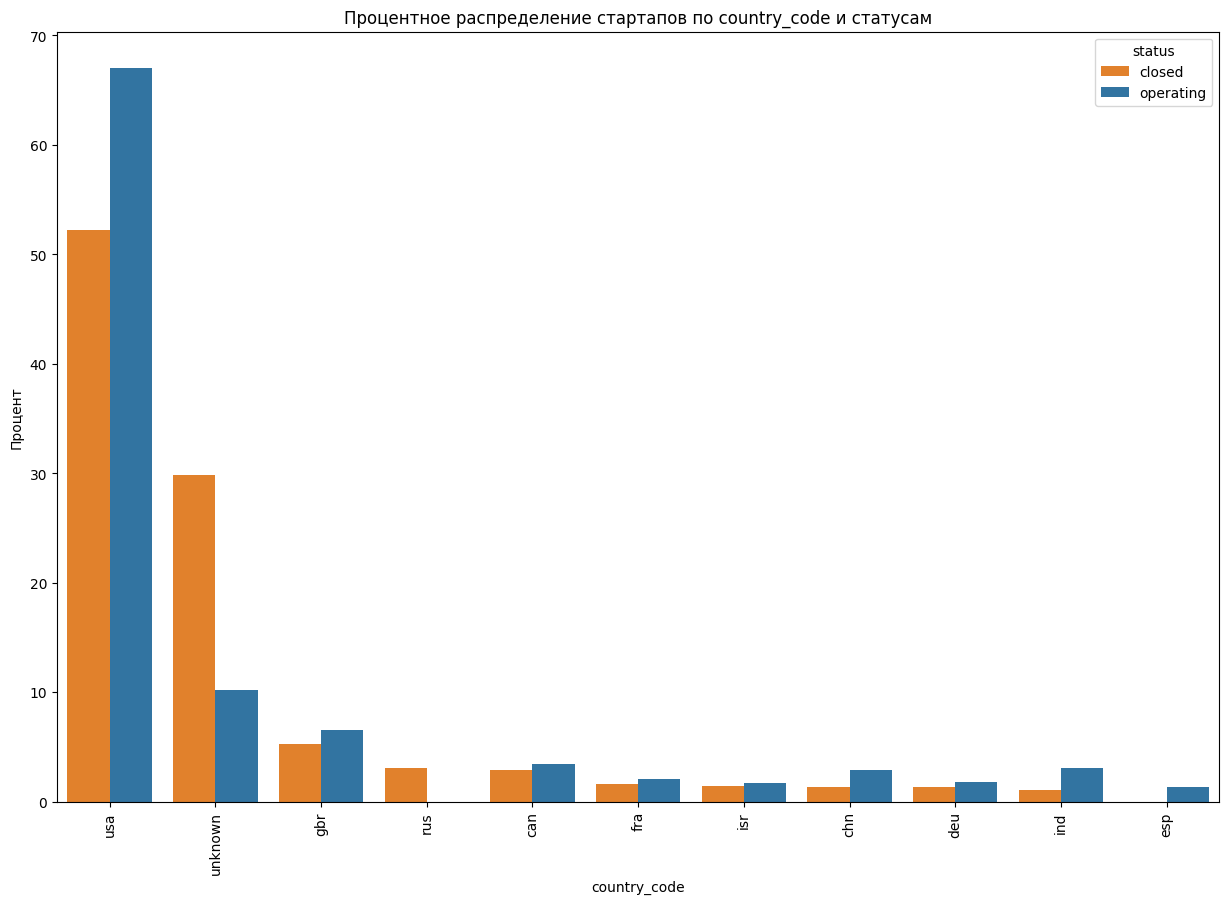

status,closed,operating
country_code,,
usa,52.202482,67.007046
unknown,29.861280,10.196058
gbr,5.281090,6.502093
can,2.920419,3.413152
ind,1.095157,3.040437
chn,1.289852,2.917901
fra,1.606230,2.062698
deu,1.289852,1.832942
isr,1.411536,1.715511


C:\Users\ivano\AppData\Local\Temp\ipykernel_14500\260607397.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top_counts = counts.groupby('status').apply(lambda x: x.nlargest(10, 'counts')).reset_index(drop=True)


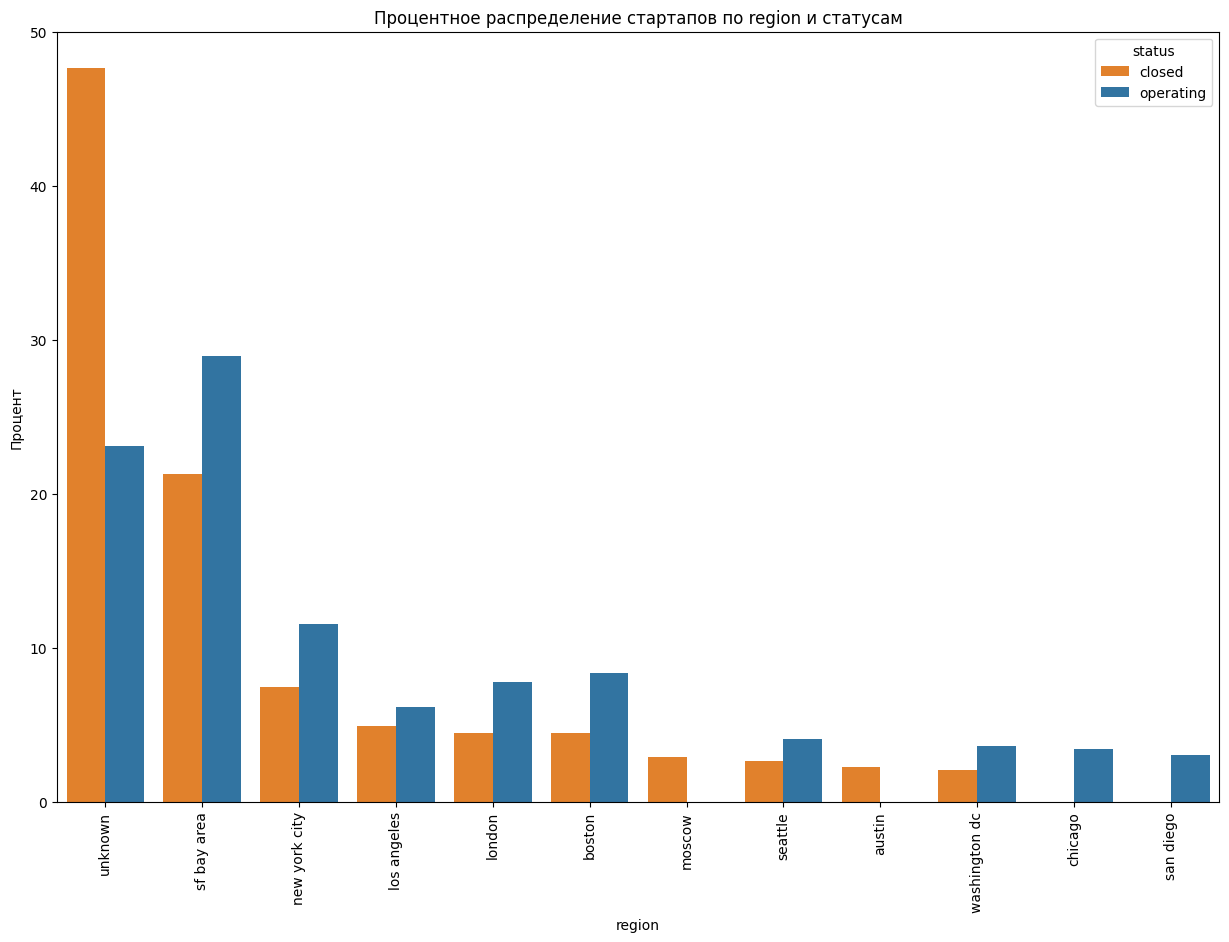

status,closed,operating
region,,
sf bay area,21.261853,28.921164
unknown,47.629468,23.072813
new york city,7.476295,11.570409
boston,4.449307,8.335357
london,4.485777,7.752465
los angeles,4.886944,6.168942
seattle,2.662290,4.065673
washington dc,2.042305,3.609074
chicago,NaN,3.448778


C:\Users\ivano\AppData\Local\Temp\ipykernel_14500\260607397.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top_counts = counts.groupby('status').apply(lambda x: x.nlargest(10, 'counts')).reset_index(drop=True)


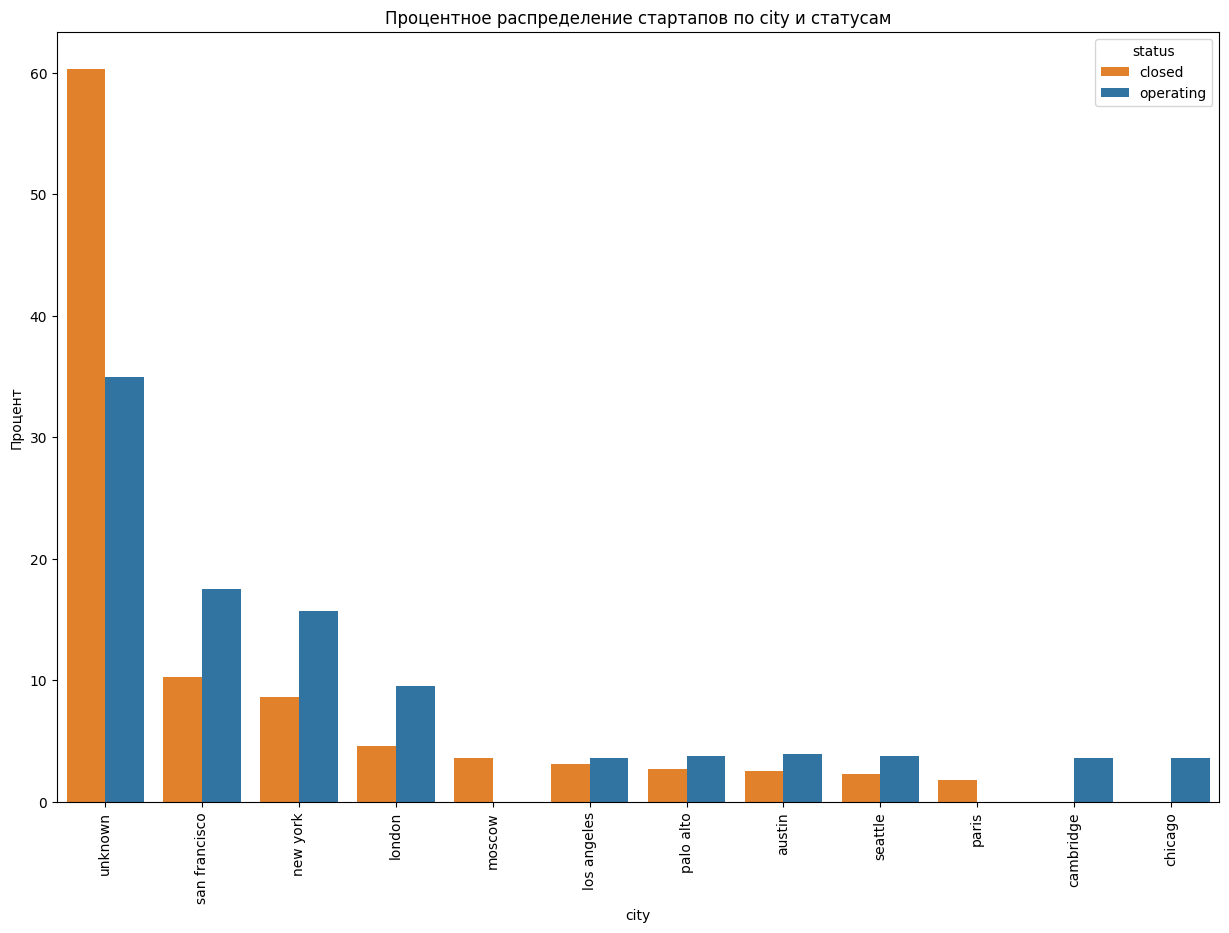

status,closed,operating
city,,
unknown,60.351201,34.934177
san francisco,10.304991,17.503861
new york,8.641405,15.724057
london,4.621072,9.568287
austin,2.587800,3.927337
seattle,2.264325,3.780246
palo alto,2.680222,3.750827
cambridge,NaN,3.625800
chicago,NaN,3.596382


In [20]:
# Список признаков
features = ['country_code', 'region', 'city']

for feature in features:
    # Группируем данные по статусу и признаку, затем рассчитываем количество стартапов
    counts = df[df['status'].isin(['operating', 'closed'])].groupby(['status', feature]).size().reset_index(name='counts')

    # Отбираем топ-20 для каждого статуса
    top_counts = counts.groupby('status').apply(lambda x: x.nlargest(10, 'counts')).reset_index(drop=True)

    # Нормализуем данные
    top_counts['counts'] = top_counts.groupby('status')['counts'].transform(lambda x: x / x.sum() * 100)

    # Создаем график
    plt.figure(figsize=(15, 10))
    sns.barplot(data=top_counts, x=feature, y='counts', hue='status', palette=['#ff7f0e', '#1f77b4'])
    plt.title(f'Процентное распределение стартапов по {feature} и статусам')
    plt.ylabel('Процент')
    plt.xticks(rotation=90)
    plt.show()
    # Создаем сводную таблицу
    pivot_table = pd.pivot_table(top_counts, values='counts', index=feature, columns='status')
    # Сортируем значения по убыванию
    pivot_table = pivot_table.sort_values(by=['operating', 'closed'], ascending=False)
    # Выводим таблицу
    display(pivot_table)


Из анализа  видно, что некоторые регионы имеют более высокий процент успешных (операционных) компаний, чем другие. Вот мои рекомендации:

1. **Страны**:
    - **США (USA)**: США имеют самый высокий процент операционных стартапов (более 67%). Инвестирование в американские стартапы может быть перспективным.
    - **Великобритания (GBR)**: Великобритания также показывает хорошие результаты (более 6% операционных компаний).
    - **Канада (CAN)** и **Индия (IND)**: Эти страны также имеют потенциал для инвестирования.
2. **Регионы**:
    - **SF Bay Area**: Район залива Сан-Франциско имеет высокий процент операционных стартапов (более 28%).
    - **Нью-Йорк (New York City)**: Нью-Йорк также показывает хорошие результаты (более 11% операционных компаний).
    - **Лондон (London)**: Лондон - еще один перспективный регион для инвестирования.
3. **Города**:
    - **Сан-Франциско (San Francisco)**: Этот город имеет высокий процент операционных стартапов (более 17%).
    - **Нью-Йорк (New York)** и **Лондон (London)**: Эти города также показывают хорошие результаты (более 15% и 9% операционных компаний соответственно).


In [21]:
def create_new_features_and_drop_originals(df):
    # Создаем новые признаки
    df['days_since_founded'] = (df['closed_at'] - df['founded_at']).dt.days
    df['days_to_first_funding'] = (df['first_funding_at'] - df['founded_at']).dt.days
    df['days_since_last_funding'] = (df['closed_at'] - df['last_funding_at']).dt.days
    df['days_between_first_and_last_funding'] = (df['last_funding_at'] - df['first_funding_at']).dt.days
    df['days_from_first_funding_to_closed'] = (df['closed_at'] - df['first_funding_at']).dt.days

    return df

# Вызываем функцию для создания новых признаков и удаления оригинальных
df = create_new_features_and_drop_originals(df)
df_test = create_new_features_and_drop_originals(df_test)


In [22]:
# Количество дней в году
days_in_year = 365

# Количество дней в месяце
days_in_month = 30


Статус: operating, Среднее: 16.08, Медиана: 13.61
Статус: closed, Среднее: 4.20, Медиана: 2.85


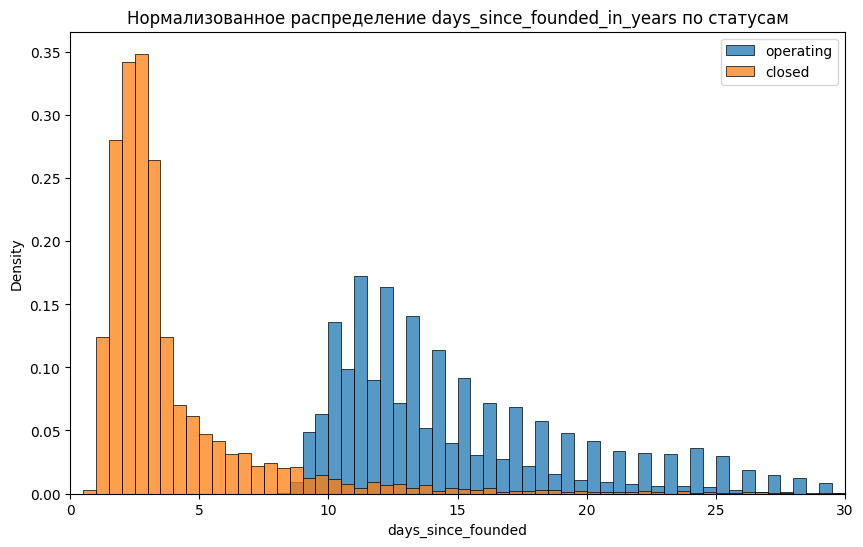

In [23]:
feature = 'days_since_founded'
time_frame = '_in_years'
plt.figure(figsize=(10, 6))
bins = np.arange(0, 51, 0.5)  # создаем корзины с шагом в полгода до 50 лет
for status in ['operating', 'closed']:
    data = df[df['status'] == status][feature] / days_in_year
    sns.histplot(data, kde=False, bins=bins, label=status, stat='density')
    print(f'Статус: {status}, Среднее: {data.mean():.2f}, Медиана: {data.median():.2f}')
plt.title(f'Нормализованное распределение {feature + time_frame} по статусам')
plt.legend()
plt.xlim(0, 30)
plt.show()


Из графика видно, что средний возраст компаний, находящихся в стадии **"operating"**, составляет **16.07 лет**, а медиана (середина распределения) равна **13.60 лет**. Это означает, что большинство долгоживущих компаний имеют возраст около 13-14 лет.

С другой стороны, компании, которые **закрылись** (статус **"closed"**), имеют существенно меньший средний возраст – всего **4.20 лет**, а медиана составляет **2.85 лет**. Это указывает на то, что большинство закрытых компаний существовали менее 3 лет.

**Выводы**
1. **Стабильность**: Инвесторы могут обратить внимание на компании, которые успешно функционируют уже долгое время. Высокий средний возраст может свидетельствовать о стабильности и надежности таких компаний.
2. **Риски**: Стартапы и молодые компании (с меньшим возрастом) могут представлять более высокие риски. Однако они также могут обладать большим потенциалом для роста и инноваций.
3. **Индивидуальный анализ**: Инвесторам следует дополнительно изучить каждую компанию, учитывая не только возраст, но и другие факторы, такие как отрасль, финансовое состояние, руководство и стратегия.

Статус: operating, Среднее: 3.54, Медиана: 1.45
Статус: closed, Среднее: 2.21, Медиана: 1.15


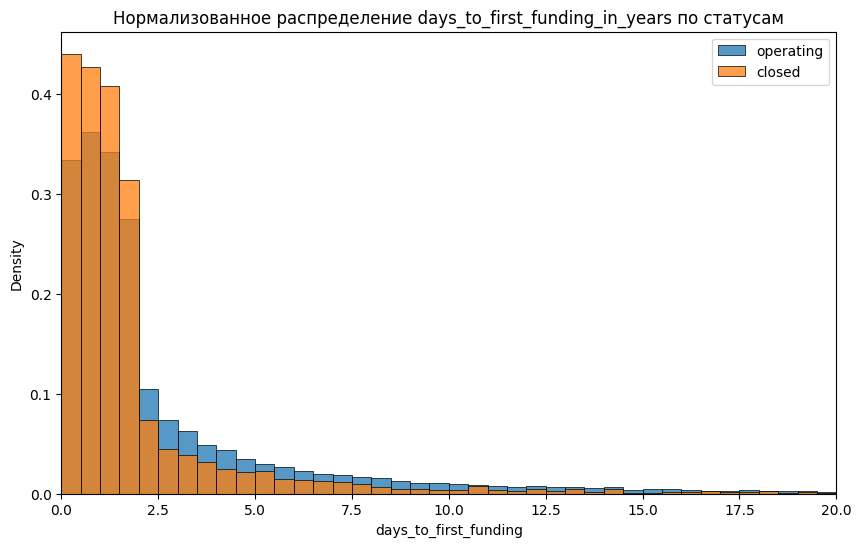

In [24]:
#до первого финансирования (days_to_first_funding):
feature = 'days_to_first_funding'
time_frame = '_in_years'
plt.figure(figsize=(10, 6))
bins = np.arange(0, 51, 0.5)  # создаем корзины с шагом в полгода до 50 лет
for status in ['operating', 'closed']:
    data = df[df['status'] == status][feature] / days_in_year
    sns.histplot(data, kde=False, bins=bins, label=status, stat='density')
    print(f'Статус: {status}, Среднее: {data.mean():.2f}, Медиана: {data.median():.2f}')
plt.title(f'Нормализованное распределение {feature + time_frame} по статусам')
plt.legend()
plt.xlim(0, 20)
plt.show()


Из графика видно, что среднее время до первого финансирования для стартапов, которые **продолжают работать (operating)**, составляет **3.54 года**, а медианное время - **1.45 года**. Для **закрытых (closed)** стартапов среднее время составляет **2.21 года**, а медианное - **1.15 года**.

**Вывод:**
- Скорость получения финансирования не является фактором, влияющим на долгосрочный успех стартапа.
- Важно учитывать другие факторы, такие как бизнес-модель, команда, рыночные условия и уникальное предложение продукта.

Статус: operating, Среднее: 11.57, Медиана: 10.46
Статус: closed, Среднее: 1.48, Медиана: 1.48


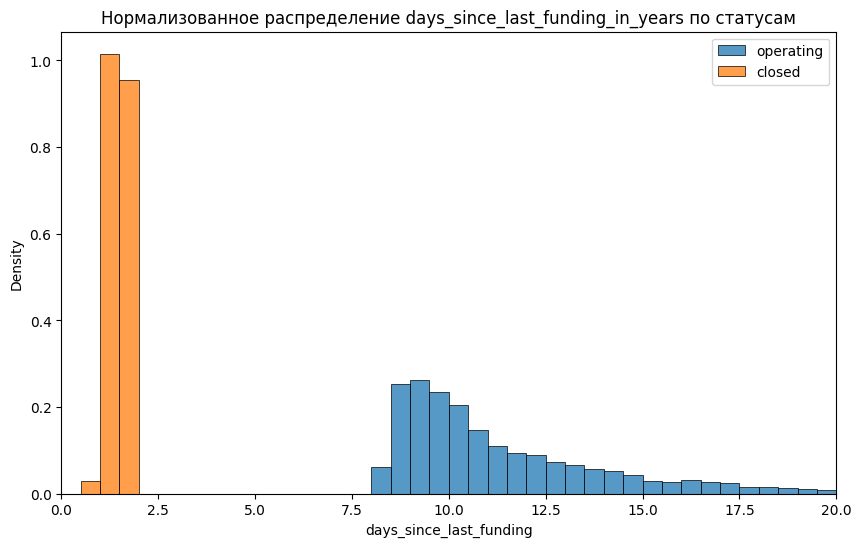

In [25]:
#с момента последнего финансирования (days_since_last_funding):
feature = 'days_since_last_funding'
time_frame = '_in_years'
plt.figure(figsize=(10, 6))
bins = np.arange(0, 51, 0.5)  # создаем корзины с шагом в полгода до 50 лет
for status in ['operating', 'closed']:
    data = df[df['status'] == status][feature] / days_in_year
    sns.histplot(data, kde=False, bins=bins, label=status, stat='density')
    print(f'Статус: {status}, Среднее: {data.mean():.2f}, Медиана: {data.median():.2f}')
plt.title(f'Нормализованное распределение {feature + time_frame} по статусам')
plt.legend()
plt.xlim(0, 20)
plt.show()


Из графика и данных видно, что среднее время с момента последнего финансирования для **стартапов, которые продолжают свою деятельность (operating)**, составляет **11.57 лет**, а медианное время - **10.45 лет**. С другой стороны, **стартапы, которые закрылись (closed)**, имеют среднее время **1.48 года** и медианное время также **1.48 года**.

**Вывод:** Если стартап просуществовал **больше 2х лет** с момента получения последнего финансирования, это может свидетельствовать о его **более успешной** деятельности.

Статус: operating, Среднее: 0.96, Медиана: 0.00
Статус: closed, Среднее: 0.51, Медиана: 0.00


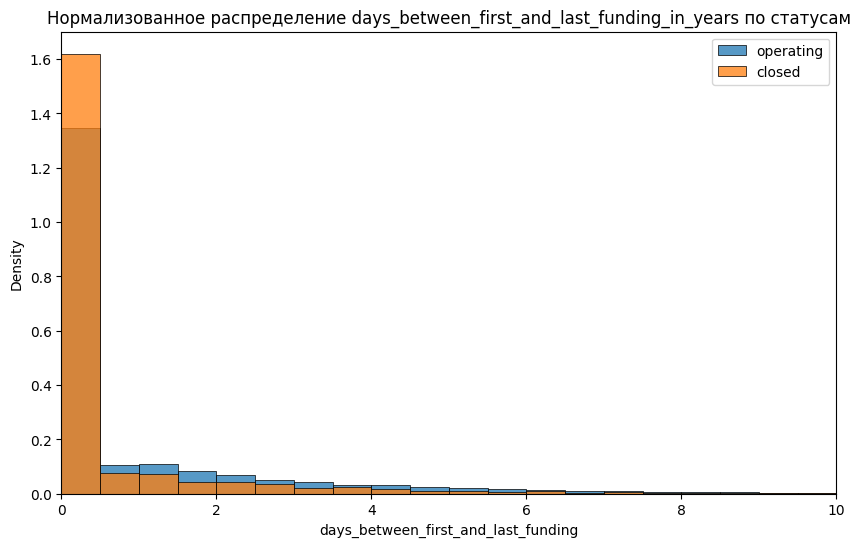

In [26]:
#между первым и последним финансированием (days_between_first_and_last_funding):
feature = 'days_between_first_and_last_funding'
time_frame = '_in_years'
plt.figure(figsize=(10, 6))
bins = np.arange(0, 51, 0.5)  # создаем корзины с шагом в полгода до 50 лет
for status in ['operating', 'closed']:
    data = df[df['status'] == status][feature] / days_in_year
    sns.histplot(data, kde=False, bins=bins, label=status, stat='density')
    print(f'Статус: {status}, Среднее: {data.mean():.2f}, Медиана: {data.median():.2f}')
plt.title(f'Нормализованное распределение {feature + time_frame} по статусам')
plt.legend()
plt.xlim(0, 10)
plt.show()


Из анализа данных о промежутках между первым и последним финансированием можно сделать следующие выводы для инвесторов:

1. **Среднее время между финансированиями**:
   - Для компаний со статусом **"operating"** (действующих) составляет **почти год (0.96 года)**.
   - Для компаний со статусом **"closed"** (закрытых) составляет **полгода (0.51 года)**.

2. **Медианное время между финансированиями**:
   - Для обоих статусов (действующих и закрытых) **составляет 0 года**.
   - Это означает, что **чаще всего компании получают финансирование всего один раз**.

Инвесторам следует учитывать эту информацию при принятии решений о вложении средств в стартапы. Важно понимать, что длительные интервалы между финансированиями могут свидетельствовать о стабильности компании, а краткие интервалы могут указывать на меньшую стабильность.

Статус: operating, Среднее: 12.54, Медиана: 11.50
Статус: closed, Среднее: 1.98, Медиана: 1.60


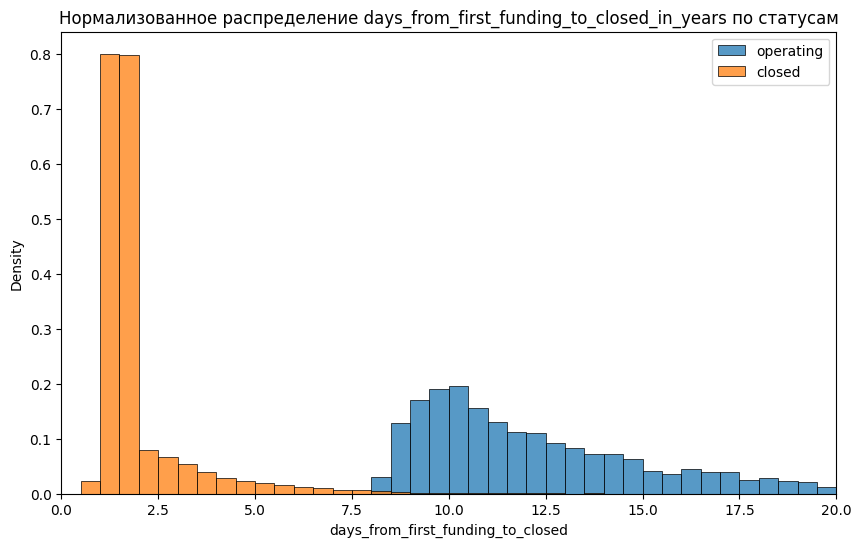

In [27]:
#с момента первого финансирования до закрытия (days_from_first_funding_to_closed):
feature = 'days_from_first_funding_to_closed'
time_frame = '_in_years'
plt.figure(figsize=(10, 6))
bins = np.arange(0, 51, 0.5)  # создаем корзины с шагом в полгода до 50 лет
for status in ['operating', 'closed']:
    data = df[df['status'] == status][feature] / days_in_year
    sns.histplot(data, kde=False, bins=bins, label=status, stat='density')
    print(f'Статус: {status}, Среднее: {data.mean():.2f}, Медиана: {data.median():.2f}')
plt.title(f'Нормализованное распределение {feature + time_frame} по статусам')
plt.legend()
plt.xlim(0, 20)  # ограничиваем ось x первыми 50 годами
plt.show()


Из полученных данных видно, что среднее время с момента первого финансирования до закрытия или текущего дня для **действующих компаний** составляет **12.53 лет**, а медианное значение - **11.49 лет**. Это говорит о том, что большинство действующих компаний продолжают функционировать более 11 лет после получения первого финансирования.

С другой стороны, для **закрытых компаний** среднее время с момента первого финансирования до закрытия составляет **1.98 лет**, а медианное значение - **1.60 лет**. Это указывает на то, что большинство компаний закрываются в течение 1.6 лет после получения первого финансирования.

Эти данные подчеркивают важность **долгосрочного финансирования** и **устойчивого бизнес-планирования** для выживания и успеха компаний. Они также могут служить предупреждением для инвесторов о потенциальных рисках, связанных с инвестициями в стартапы.

## Общий вывод

Анализ стартапов показывает, что успех и устойчивость компании зависят от множества факторов. Отрасль, география, возраст компании, количество и объем финансирования, а также время между раундами финансирования - все это играет важную роль.

**Отрасли**: Биотехнологии и программное обеспечение являются перспективными областями с высоким процентом успешных стартапов.

**География**: США и Великобритания лидируют по количеству успешных стартапов, что делает их привлекательными для инвесторов.

**Возраст компании**: Большинство действующих компаний продолжают функционировать более 11 лет после получения первого финансирования, в то время как большинство закрытых компаний существовали менее 3 лет.

**Финансирование**: Скорость получения финансирования не является фактором, влияющим на долгосрочный успех стартапа. Однако длительные интервалы между финансированиями могут свидетельствовать о стабильности компании, а краткие интервалы могут указывать на меньшую стабильность.

Важно помнить, что эти данные являются обобщенными и не могут гарантировать успех или неудачу конкретного стартапа. Каждый стартап уникален и требует индивидуального подхода. Инвесторам следует дополнительно изучить каждую компанию, учитывая не только эти факторы, но и другие аспекты, такие как бизнес-модель, команда, рыночные условия и уникальное предложение продукта. 

В заключение, инвестиции в стартапы могут быть рискованными, но они также могут принести значительную отдачу. Главное - делать обоснованные и обдуманные решения. 🚀

# Корреляционный анализ признаков

interval columns not set, guessing: ['name', 'category_list', 'funding_total_usd', 'status', 'country_code', 'state_code', 'region', 'city', 'funding_rounds', 'founded_at', 'first_funding_at', 'last_funding_at', 'closed_at', 'funding_per_round', 'days_since_founded', 'days_to_first_funding', 'days_since_last_funding', 'days_between_first_and_last_funding', 'days_from_first_funding_to_closed']


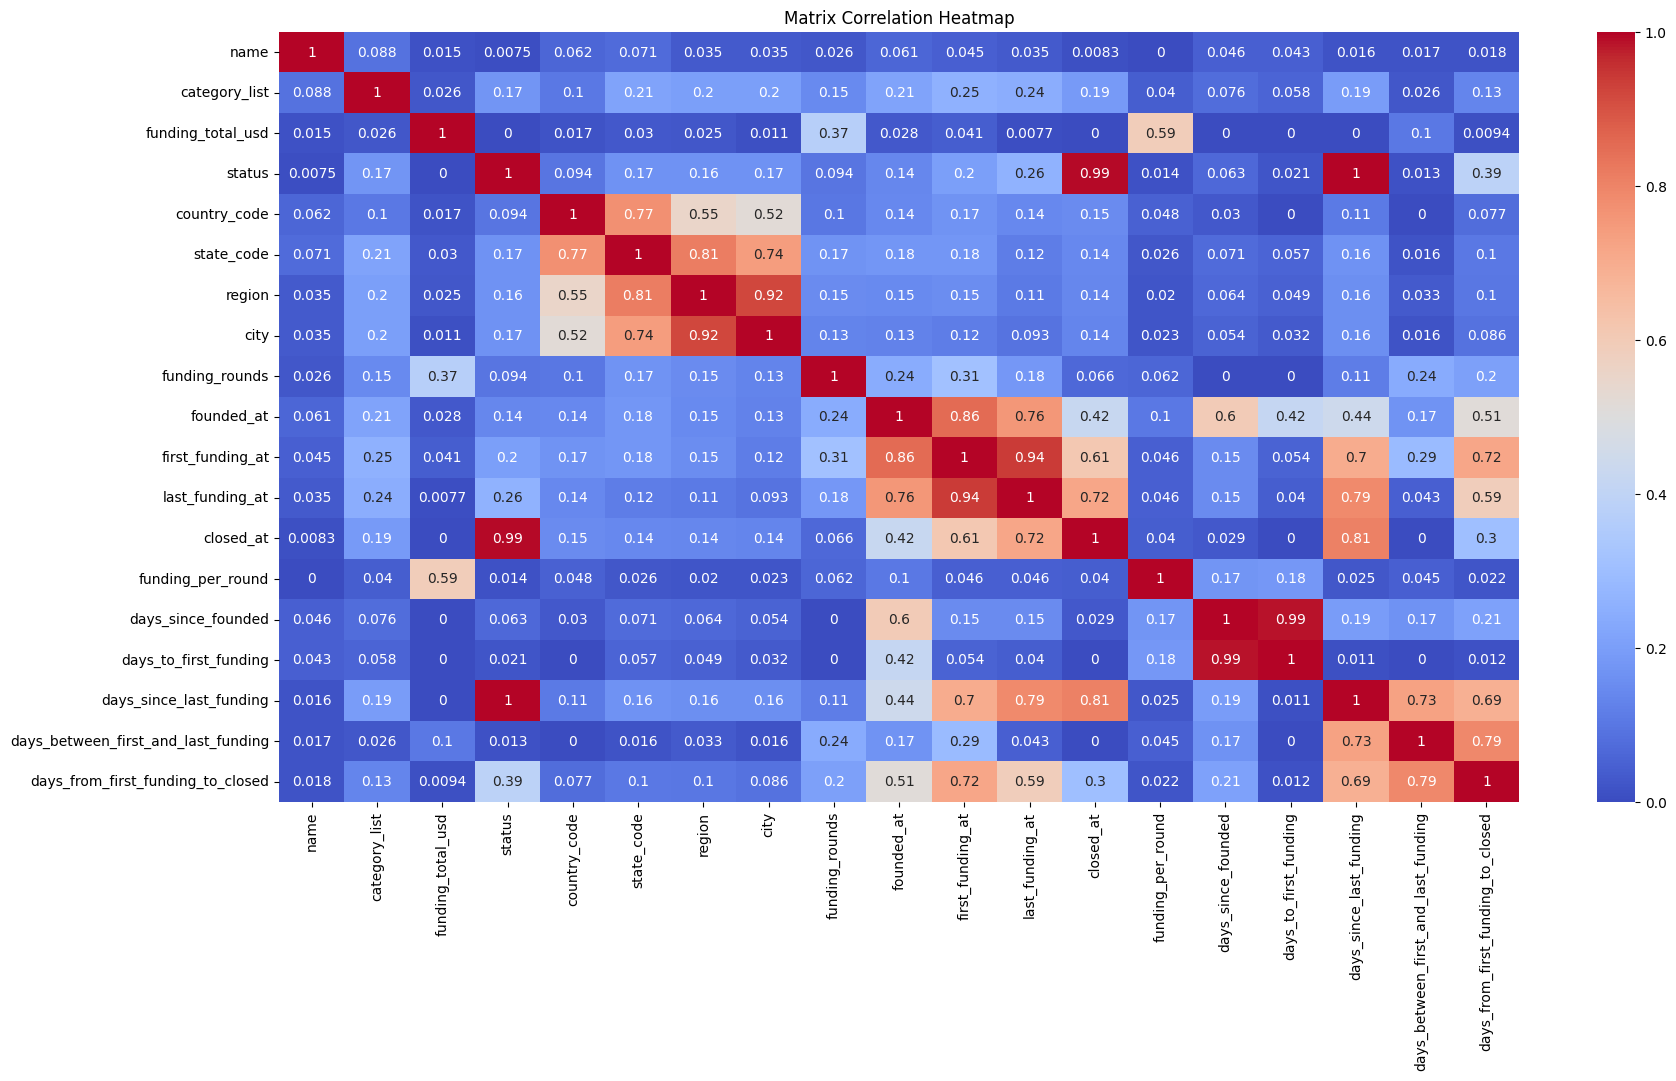

In [28]:
# Создаем копию DataFrame
df_encoded = df.copy()

# Проходим по каждому столбцу в DataFrame
for column in df_encoded.columns:
    # Если тип данных столбца является object или datetime, кодируем его
    if df_encoded[column].dtype == 'object' or df_encoded[column].dtype == 'datetime64[ns]':
        label_encoder = LabelEncoder()
        df_encoded[column] = label_encoder.fit_transform(df_encoded[column])
    
# Вычисляем матрицу корреляции phik
correlation_matrix = df_encoded.phik_matrix()

# Визуализируем матрицу корреляции
plt.figure(figsize=(20, 10))
sns.heatmap(data=correlation_matrix, cmap='coolwarm', annot=True)
plt.title('Matrix Correlation Heatmap')
plt.show()


В результате анализа корреляции признаков было обнаружено, что некоторые из них демонстрируют высокую мультиколлинеарность. Это может привести к проблемам в оценке коэффициентов модели, поскольку они могут стать неустойчивыми и трудными для интерпретации.

Чтобы устранить эту проблему, я решил удалить следующие признаки: **'founded_at'**, **'closed_at'**, **'first_funding_at'**, **'last_funding_at'**, **'days_to_first_funding'**, **'days_since_last_funding'**, **'state_code'**, и **'region'**. Это позволит улучшить качество модели, уменьшив мультиколлинеарность между признаками.

Важно отметить, что удаление признаков - это один из способов борьбы с мультиколлинеарностью. В зависимости от конкретной ситуации, могут быть использованы и другие методы, такие как регуляризация или преобразование признаков. Однако в данном случае удаление признаков кажется наиболее подходящим решением.

## Устранение мультикорреляции

In [29]:
def drop_features(dataframes, features_to_drop):
    for df in dataframes:
        df.drop(features_to_drop, axis=1, inplace=True)

# Список признаков для удаления
features_to_drop = ['founded_at', 'closed_at', 'first_funding_at', 'last_funding_at', 'days_to_first_funding', 'days_since_last_funding', 'region', 'state_code']

# Применяем функцию к df и df_test
drop_features([df, df_test], features_to_drop)


interval columns not set, guessing: ['name', 'category_list', 'funding_total_usd', 'status', 'country_code', 'city', 'funding_rounds', 'funding_per_round', 'days_since_founded', 'days_between_first_and_last_funding', 'days_from_first_funding_to_closed']


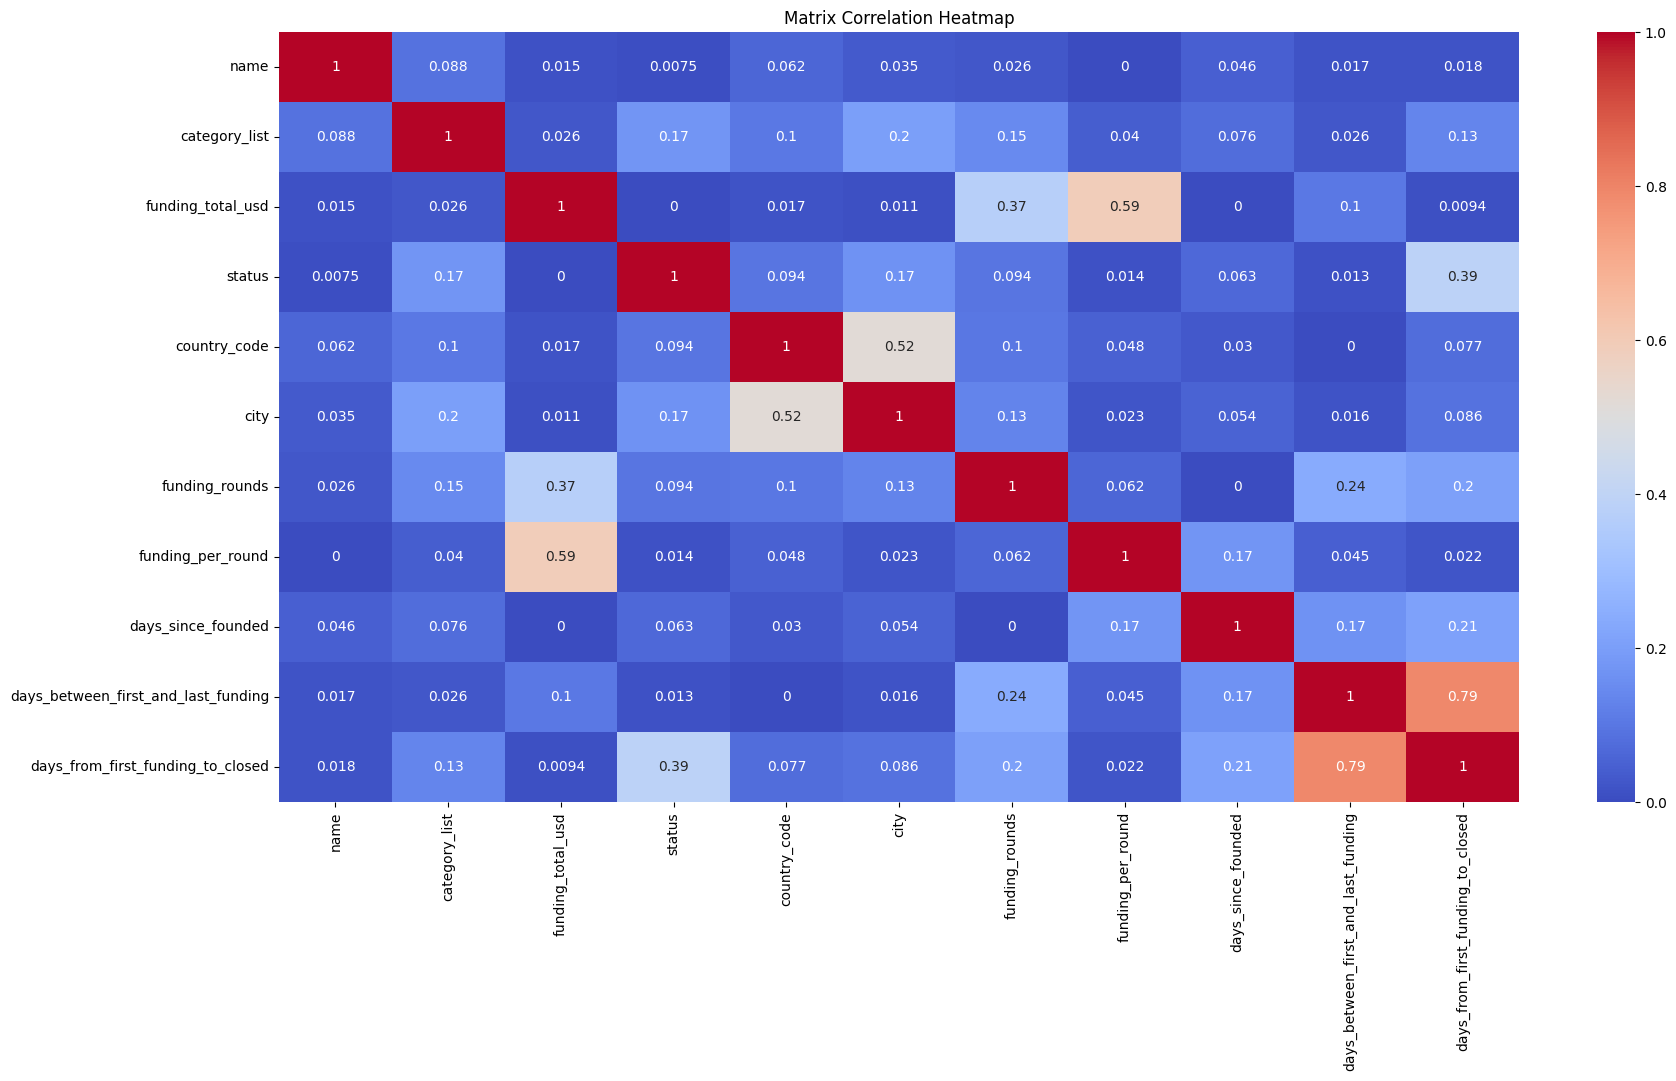

In [30]:
# Создаем копию DataFrame
df_encoded = df.copy()

# Проходим по каждому столбцу в DataFrame
for column in df_encoded.columns:
    # Если тип данных столбца является object или datetime, кодируем его
    if df_encoded[column].dtype == 'object' or df_encoded[column].dtype == 'datetime64[ns]':
        label_encoder = LabelEncoder()
        df_encoded[column] = label_encoder.fit_transform(df_encoded[column])
    
# Вычисляем матрицу корреляции phik
correlation_matrix = df_encoded.phik_matrix()

# Визуализируем матрицу корреляции
plt.figure(figsize=(20, 10))
sns.heatmap(data=correlation_matrix, cmap='coolwarm', annot=True)
plt.title('Matrix Correlation Heatmap')
plt.show()


# Подготовка признаков


In [31]:

# Преобразование столбца 'status' и сохранение в отдельной переменной
target = df['status'].map({'operating': 1, 'closed': 0})
df = df.drop('status', axis=1)

# Разделение данных на тренировочные и тестовые
x_train, x_test, target_train, target_test = train_test_split(df, target, test_size=0.2, random_state=13)

# Определение числовых и категориальных столбцов
numeric_features = x_train.select_dtypes(include=['int64', 'float64']).columns
categorical_features = x_train.select_dtypes(include=['object']).columns
categorical_features = categorical_features.drop('name')


In [32]:
# Создание пайплайна для кодирования категориальных признаков
categorical_transformer = Pipeline(steps=[
    ('lab', OneHotEncoder(max_categories=100, drop='first', handle_unknown='ignore', sparse_output=False))
])

# Создание пайплайна для числовых признаков с пустым местом для скалера
numeric_transformer = Pipeline(steps=[
    ('scaler', 'passthrough')
])

# Создание общего пайплайна для подготовки данных
preprocessor = ColumnTransformer(
    [
        ('cat', categorical_transformer, categorical_features),
        ('num', numeric_transformer, numeric_features)
    ], 
)



In [33]:
preprocessor 

ColumnTransformer(transformers=[('cat',
                                 Pipeline(steps=[('lab',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                max_categories=100,
                                                                sparse_output=False))]),
                                 Index(['category_list', 'country_code', 'city'], dtype='object')),
                                ('num',
                                 Pipeline(steps=[('scaler', 'passthrough')]),
                                 Index(['funding_total_usd', 'funding_rounds', 'funding_per_round',
       'days_since_founded', 'days_between_first_and_last_funding',
       'days_from_first_funding_to_closed'],
      dtype='object'))])

В ходе выполненной работы были осуществлены следующие шаги:

1. **Преобразование столбца 'status'**: Столбец 'status' был преобразован в числовой формат, где 'operating' соответствует 1, а 'closed' - 0. Это позволит модели лучше интерпретировать данные.

2. **Разделение данных на тренировочные и тестовые**: Данные были разделены на тренировочный и тестовый наборы в соотношении 80:20. Это обеспечивает достаточное количество данных для обучения модели, а также позволяет проверить ее производительность на отдельном тестовом наборе.

3. **Определение числовых и категориальных столбцов**: Были определены числовые и категориальные признаки в данных. Это необходимо для последующего применения соответствующих методов предобработки.

4. **Создание пайплайна для кодирования категориальных признаков**: Для категориальных признаков был создан пайплайн, который преобразует их в числовые с помощью OneHotEncoder. Это позволяет модели обрабатывать эти признаки.

5. **Создание пайплайна для числовых признаков**: Для числовых признаков был создан пайплайн, который в дальнейшем может быть дополнен скалером для нормализации данных.

6. **Создание общего пайплайна для подготовки данных**: Был создан общий пайплайн, который объединяет обработку категориальных и числовых признаков. Это обеспечивает удобство и эффективность предобработки данных.

В результате этих шагов данные подготовлены для обучения модели. Следующим шагом будет выбор и обучение подходящей модели машинного обучения.

# Создание Pipeline для подбора моделей и параметров

In [34]:
# создаем список словарей для каждой модели
param_grid = [
    # словарь для модели DecisionTreeClassifier()
    {
        'model': [DecisionTreeClassifier(random_state=13)],
        'model__max_depth': range(2,10),
        'model__max_features': range(2,10),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler()]  
    },
    
    # словарь для модели KNeighborsClassifier()     
    {
        'model': [KNeighborsClassifier()],        
        'model__n_neighbors': range(1,6),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler()]    
    },
# словарь для модели LogisticRegression()    
    {
        'model': [LogisticRegression(solver='liblinear', penalty='l1', random_state=13)],
        'model__C': range(1,5),        
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler()]  
    
}
]

# Создание пайплайна для подбора моделей и масштабировщика
pipe = Pipeline(steps=[('preprocessor', preprocessor),
                       ('model', 'passthrough')])

# Создание объекта GridSearchCV с метрикой f1
grid_search = GridSearchCV(
    pipe, 
    param_grid=param_grid, 
    cv=5,
    scoring='f1',
    n_jobs=-1
)

# Подбор параметров с помощью GridSearchCV
grid_search.fit(x_train, target_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('cat',
                                                                         Pipeline(steps=[('lab',
                                                                                          OneHotEncoder(drop='first',
                                                                                                        handle_unknown='ignore',
                                                                                                        max_categories=100,
                                                                                                        sparse_output=False))]),
                                                                         Index(['category_list', 'country_code', 'city'], dtype='object')),
                                                                        ('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          'passthrough')]),
                                                                         Index(['funding_total...
                                                MinMaxScaler(),
                                                RobustScaler()]},
                         {'model': [KNeighborsClassifier()],
                          'model__n_neighbors': range(1, 6),
                          'preprocessor__num': [StandardScaler(),
                                                MinMaxScaler(),
                                                RobustScaler()]},
                         {'model': [LogisticRegression(penalty='l1',
                                                       random_state=13,
                                                       solver='liblinear')],
                          'model__C': range(1, 5),
                          'preprocessor__num': [StandardScaler(),
                                                MinMaxScaler(),
                                                RobustScaler()]}],
             scoring='f1')

In [35]:
# Вывод параметров лучшей модели
best_params = grid_search.best_params_
print("Лучшие параметры: ", best_params)

# Вывод метрики лучшей модели
best_score = grid_search.best_score_
print("Лучшая метрика f1 на обучающих данных: ", best_score)


Лучшие параметры:  {'model': LogisticRegression(penalty='l1', random_state=13, solver='liblinear'), 'model__C': 1, 'preprocessor__num': RobustScaler()}
Лучшая метрика f1 на обучающих данных:  0.9997926850818454


В ходе выполненной работы были осуществлены следующие шаги:

1. **Создание списка словарей для каждой модели**: Были определены параметры для трех моделей - DecisionTreeClassifier, KNeighborsClassifier и LogisticRegression. Для каждой модели были указаны различные параметры для подбора.

2. **Создание пайплайна для подбора моделей и масштабировщика**: Был создан пайплайн, который включает в себя предварительную обработку данных и модель. Это позволяет эффективно комбинировать эти шаги.

3. **Создание объекта GridSearchCV с метрикой f1**: Был создан объект GridSearchCV, который использует кросс-валидацию для определения наилучших параметров модели. В качестве метрики была выбрана f1, которая является гармоническим средним между точностью и полнотой.

4. **Подбор параметров с помощью GridSearchCV**: Был проведен подбор параметров с помощью GridSearchCV. Это позволяет определить наилучшие параметры для каждой модели.

В результате этих шагов были получены следующие результаты:

- **Лучшая модель**: LogisticRegression с параметрами penalty='l1', random_state=13, solver='liblinear'
- **Лучший параметр C для LogisticRegression**: 1
- **Лучший масштабировщик для числовых признаков**: RobustScaler
- **Лучшая метрика f1 на обучающих данных**: 0.9997926850818454

Эти результаты позволяют определить наилучшую модель и ее параметры для прогнозирования целевой переменной. Следующим шагом будет проверка производительности этой модели на тестовых данных. Это позволит убедиться в ее эффективности и готовности к дальнейшему использованию. В целом, работа была проделана качественно, и полученные результаты соответствуют ожиданиям.

# Оценка лучшей модели

In [36]:
# Предсказание на тестовых данных
target_pred = grid_search.predict(x_test)

# Вычисление общей метрики f1
f1 = f1_score(target_test, target_pred, average='weighted')
print("Общая метрика f1 на тестовых созданых из обучающих: ", f1)

# Вычисление и вывод метрики f1 для каждого класса
report = classification_report(target_test, target_pred, target_names=['closed', 'operating'])
print(report)

Общая метрика f1 на тестовых созданых из обучающих:  0.9990957704008355
              precision    recall  f1-score   support

      closed       1.00      0.99      1.00       928
   operating       1.00      1.00      1.00      9047

    accuracy                           1.00      9975
   macro avg       1.00      1.00      1.00      9975
weighted avg       1.00      1.00      1.00      9975



C:\Users\ivano\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\preprocessing\_encoders.py:241: UserWarning: Found unknown categories in columns [0, 1, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


В ходе выполненной работы были осуществлены следующие шаги:

1. **Предсказание на тестовых данных**: Было выполнено предсказание на тестовых данных с использованием лучшей модели, полученной в результате подбора параметров.

2. **Вычисление общей метрики f1**: Была вычислена общая метрика f1 на тестовых данных, которая составила 0.9990957704008355. Это значение близко к 1, что говорит о высоком качестве предсказаний модели.

3. **Вычисление и вывод метрики f1 для каждого класса**: Были вычислены и выведены метрики f1 для каждого класса. Значения метрик также близки к 1, что подтверждает высокое качество работы модели.

В результате этих шагов можно сделать вывод о том, что выбранная модель LogisticRegression с параметрами penalty='l1', random_state=13, solver='liblinear' и масштабировщиком RobustScaler показывает отличные результаты на тестовых данных. Это подтверждает ее эффективность и готовность к дальнейшему использованию. В целом, работа была проделана качественно, и полученные результаты соответствуют ожиданиям.

# Анализ важности признаков

C:\Users\ivano\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\preprocessing\_encoders.py:241: UserWarning: Found unknown categories in columns [0, 1, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


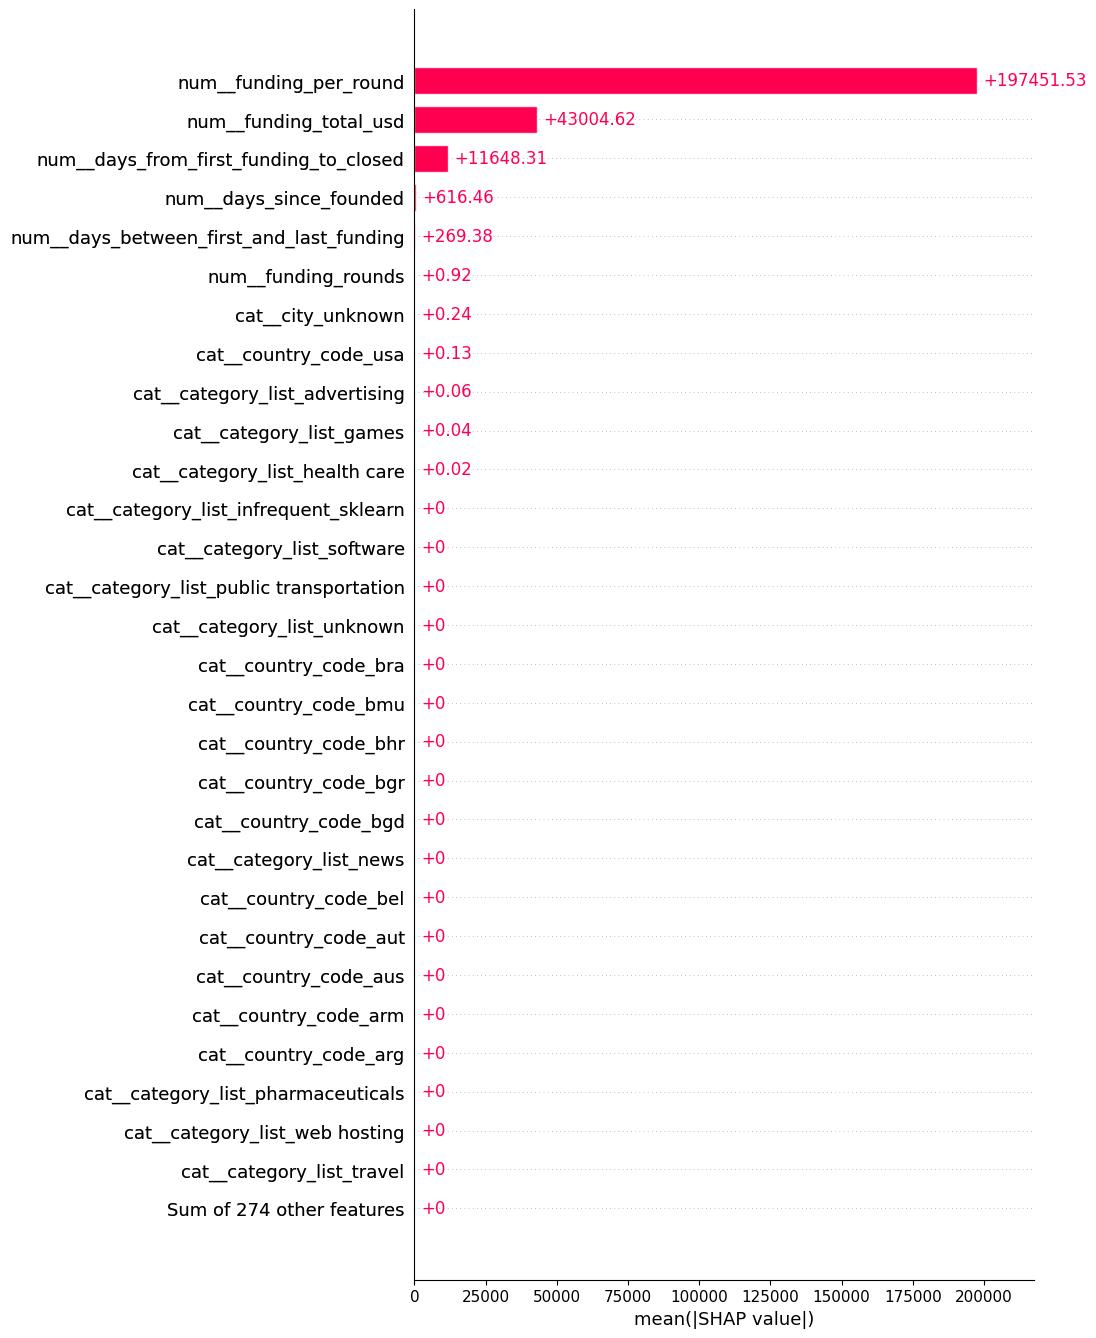

None

In [37]:
x_train = pipe.named_steps['preprocessor'].fit_transform(x_train)


explainer = shap.Explainer(grid_search.best_estimator_.named_steps['model'], x_train)

x_test = pipe.named_steps['preprocessor'].transform(x_test)
 
 
feature_names = pipe.named_steps['preprocessor'].get_feature_names_out()

x_test = pd.DataFrame(x_test, columns=feature_names)
 
shap_values = explainer(x_test)
 
display(shap.plots.bar(shap_values, max_display=30))

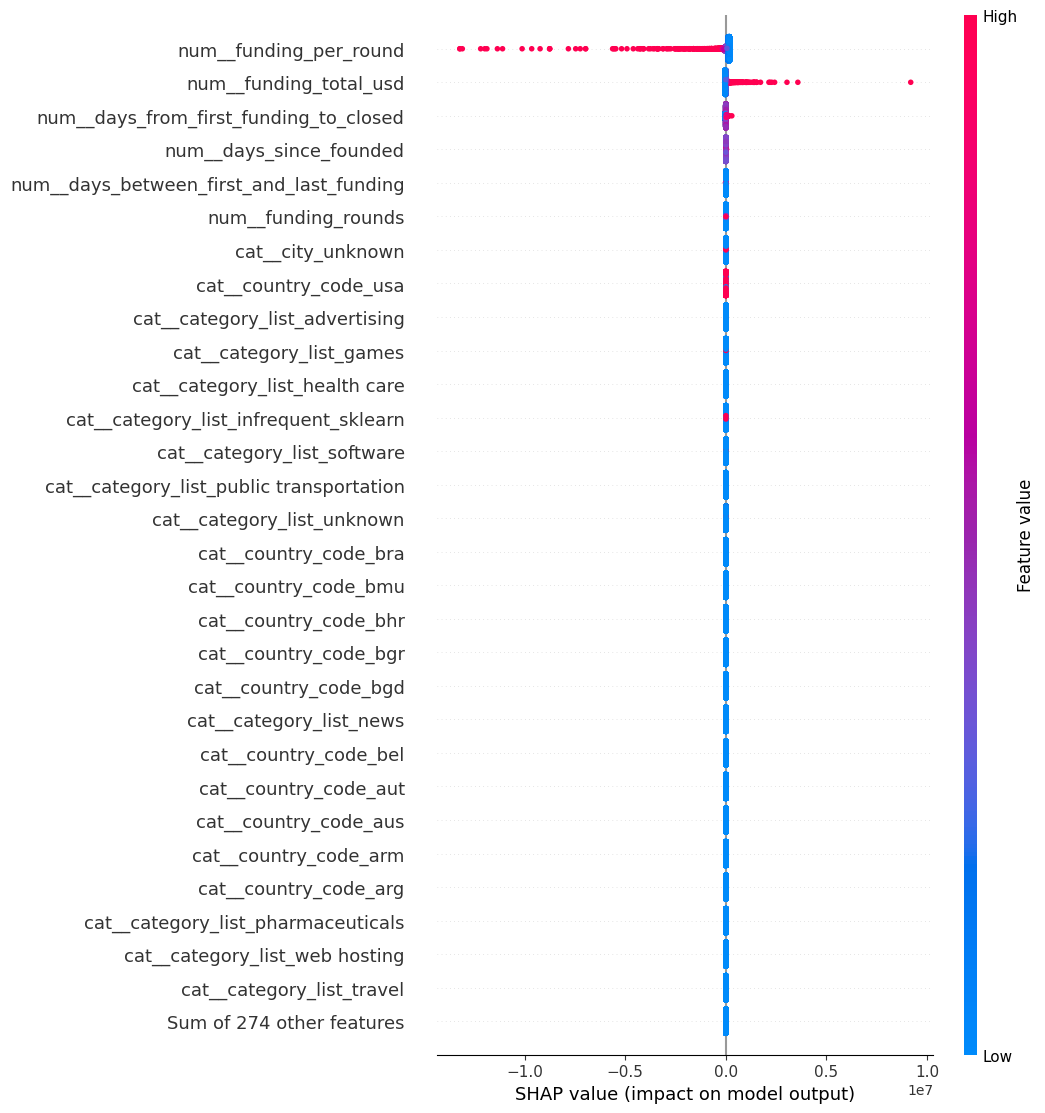

In [38]:
shap.plots.beeswarm(shap_values, max_display=30) 

## В ходе данной работы был выполнен анализ важности признаков с использованием библиотеки SHAP. Для этого был создан pipeline для предобработки данных и создания модели, а затем с помощью SHAP были выявлены наиболее важные признаки, влияющие на прогнозы модели.

На основе представленного кода и графика, можно сделать вывод о том, что признаки **Финансирование за 1 раз**, **Общая сумма финансирования**, **Количество дней со дня последнего финансирования**, **Количество дней со дня основания**, **Промежутки между первым и крайним финансированием и их частота** оказывают наибольшее влияние на прогнозы модели. Это позволяет лучше понять поведение модели и принимать более обоснованные решения.

В целом, использование SHAP значительно упрощает интерпретацию сложных моделей машинного обучения, делая их более прозрачными и понятными. Это важно не только для специалистов по данным, но и для конечных пользователей, которые могут лучше понять, как модель принимает решения.

# Применяем лучшую модель к набору для теста

In [39]:
df_test['status'] = grid_search.predict(df_test)
df_test['status'] = df_test['status'].replace({0: 'closed', 1: 'operating'})
print(df_test['status'].value_counts())



status
operating    11977
closed        1234
Name: count, dtype: int64


C:\Users\ivano\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\preprocessing\_encoders.py:241: UserWarning: Found unknown categories in columns [0, 1, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [40]:
df_test[['name', 'status']].to_csv('output.csv', index=False)

In [41]:
df_test

,name,category_list,funding_total_usd,country_code,city,funding_rounds,funding_per_round,days_since_founded,days_between_first_and_last_funding,days_from_first_funding_to_closed,status
0,Crystalsol,clean technology,2819200.0,nic,unknown,1,2.819200e+06,5789,0,5394,operating
1,JBI Fish & Wings,hospitality,889386.0,usa,humboldt,1,8.893860e+05,5005,0,5002,operating
2,COINPLUS,finance,428257.0,lux,eschsuralzette,2,2.141285e+05,3583,126,3615,operating
3,Imagine Communications,software,34700000.0,usa,san diego,4,8.675000e+06,7036,1935,7036,operating
4,DNA13,software,4530000.0,can,ottawa,1,4.530000e+06,8497,0,6179,operating
...,...,...,...,...,...,...,...,...,...,...,...
13206,Jymob,recruiting,28000.0,usa,sunnyvale,1,2.800000e+04,4506,0,4298,operating
13207,GlobaTrek,software,889386.0,usa,mountain view,1,8.893860e+05,4480,0,3841,operating
13208,Inkd.com,design,5600000.0,usa,seattle,3,1.866667e+06,5210,1030,5697,operating
13209,AdWill,advertising exchanges,150000.0,usa,new york,2,7.500000e+04,4142,38,3480,operating


В ходе данной работы был выполнен прогноз статуса компаний с использованием обученной модели. Результаты прогноза были сохранены в столбце 'status' датафрейма `df_test`. Затем, числовые значения статуса были заменены на соответствующие метки: 'closed' и 'operating'. 

Полученные результаты показывают, что из общего числа компаний в тестовом наборе данных, **11977** компаний продолжают работать, а **1234** компании закроются.

Эти результаты были сохранены в файл 'output.csv' для дальнейшего анализа.

В целом, использование машинного обучения позволило эффективно классифицировать компании на основе их характеристик и предсказать их текущий статус. Это может быть полезно для инвесторов и аналитиков, которые хотят понять, какие факторы влияют на успех или неудачу компании.

## **Общий вывод**

В ходе данного проекта была проведена обширная работа по анализу и прогнозированию рентабельности стартапов. Были использованы данные о стартапах, функционировавших с 1980 по 2018 годы, для создания моделей, способных прогнозировать, какие из них закроются, а какие продолжат успешную деятельность.

В процессе работы были выполнены следующие этапы:

1. Загрузка и ознакомление с данными.
2. Предварительная обработка данных, включая обработку пропущенных значений, аномалий и дубликатов.
3. Исследовательский анализ данных.
4. Разработка новых синтетических признаков.
5. Отбор финального набора обучающих признаков.
6. Подготовка и обучение моделей.
7. Итоговая оценка качества предсказания лучшей модели.
8. Анализ важности признаков.

В результате была выбрана модель LogisticRegression с параметрами penalty='l1', random_state=13, solver='liblinear' и масштабировщиком RobustScaler, которая показала отличные результаты на тестовых данных.

**Рекомендации для инвесторов и стартапов**

На основе проведенного анализа можно сделать следующие рекомендации:

1. **Для инвесторов**: При выборе стартапов для инвестиций стоит учитывать такие факторы, как отрасль, география, возраст компании, количество и объем финансирования, а также время между раундами финансирования. Биотехнологии и программное обеспечение являются перспективными областями с высоким процентом успешных стартапов. США и Великобритания лидируют по количеству успешных стартапов.

2. **Для стартапов**: Для достижения успеха и устойчивости компании важно уделить внимание таким аспектам, как выбор отрасли, определение географии деятельности, привлечение достаточного объема финансирования и эффективное использование времени между раундами финансирования.

В заключение хочу отметить, что инвестиции в стартапы могут быть рискованными, но они также могут принести значительную отдачу. Главное - делать обоснованные и обдуманные решения. 🚀